<a href="https://colab.research.google.com/github/costaer/PIQueimadas/blob/main/PIQueimadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto integrador IV Univesp Segundo semestre 2025

# Desenvolvimento de API para Previsão de Risco de Queimadas

## Objetivo do Projeto

O objetivo deste projeto é desenvolver uma API para previsão de risco de queimadas na região de São José do Rio Preto, SP. Para isso, selecionamos áreas com características climáticas e agrícolas compatíveis à região de interesse, utilizando dados meteorológicos de estações automáticas do INMET.

---

## Justificativa da Escolha das Áreas

Optou-se por estações localizadas em regiões agrícolas do interior paulista, como Votuporanga, José Bonifácio, Jales, Ariranha, Barretos, Bebedouro e Presidente Prudente. Essas áreas apresentam condições climáticas e de uso do solo semelhantes às de São José do Rio Preto, garantindo a representatividade dos dados para o treinamento do modelo preditivo.

---

## Dados Meteorológicos Selecionados

Os dados meteorológicos foram coletados a partir do [Banco de Dados Meteorológicos do INMET (BDMEP)](https://bdmep.inmet.gov.br/), abrangendo o período de 01/01/2015 a 31/12/2024. As variáveis selecionadas incluem:

- Precipitação Total Horária
- Pressão Atmosférica ao Nível da Estação (Horária)
- Pressão Atmosférica Reduzida ao Nível do Mar (Automática)
- Pressão Atmosférica Máxima na Hora Anterior (Automática)
- Pressão Atmosférica Mínima na Hora Anterior (Automática)
- Radiação Global
- Temperatura da CPU da Estação
- Temperatura do Ar - Bulbo Seco (Horária)
- Temperatura do Ponto de Orvalho
- Temperatura Máxima na Hora Anterior (Automática)
- Temperatura Mínima na Hora Anterior (Automática)
- Temperatura do Orvalho Máxima na Hora Anterior (Automática)
- Temperatura do Orvalho Mínima na Hora Anterior (Automática)
- Tensão da Bateria da Estação
- Umidade Relativa Máxima na Hora Anterior (Automática)
- Umidade Relativa Mínima na Hora Anterior (Automática)
- Umidade Relativa do Ar (Horária)
- Vento - Direção Horária
- Vento - Rajada Máxima
- Vento - Velocidade Horária

---

## Estações Selecionadas

As estações automáticas do INMET selecionadas para coleta dos dados são:

- Ariranha (A736)
- Barretos (A748)
- Bebedouro (A764)
- Jales (A733)
- José Bonifácio (A735)
- Lins (A727)
- Presidente Prudente (A707)
- Votuporanga (A729)

Essas estações foram escolhidas por estarem localizadas em regiões com características climáticas e agrícolas semelhantes às de São José do Rio Preto, garantindo a representatividade dos dados para o modelo preditivo.

A fim de garantir uma abrangência maior e conseguir utilizar a região que estamos estudando, foi requerido junto com o CIIAGRO dados das estações:

- Mirassol (V0419)
- Monte Aprasível (V0428)
- Nhandeara (V0433)
- Nova Granada (V0434)



---

## Acesso aos Dados

Os dados meteorológicos podem ser acessados através do [Banco de Dados Meteorológicos do INMET (BDMEP)](https://bdmep.inmet.gov.br/), onde é possível selecionar as estações, variáveis e período desejados para download.

os dados do CIIAGRO foi necessário pedir acesso, cedido no Banco de dados da rede meteorológica do Centro Integrado de Informações Agrometeorológicas - CIIAGRO.

---

## Dados de Queimadas

Para correlacionar os dados meteorológicos com eventos de queimadas, utilizamos os dados do [Sistema de Monitoramento de Queimadas do INPE](https://queimadas.dgi.inpe.br/queimadas/portal-static/estatisticas.html), que fornecem informações sobre focos de queimada, incluindo data, hora, localização e intensidade.

---

## Desenvolvimento do Modelo Preditivo

Com os dados meteorológicos e de queimadas correlacionados, será possível treinar um modelo de aprendizado de máquina para prever o risco de incêndios na região de São José do Rio Preto. Variáveis como umidade do ar, temperatura, precipitação e radiação solar serão fundamentais para a acurácia do modelo.

# Inicio da importação dos dados e criação do banco que será utilizado

**Unificação dos arquivos do INMET e tratamento da coluna Data medicao e Hora medicao para uma coluna só e adicionada coluna cidade para depois unificar com dados do INPE**

In [107]:
# Imports
import pandas as pd
import glob
import os

# Caminho da base no Google Drive para os dados do INMET
caminho_dados_inmet = '/content/drive/MyDrive/Estudos/Univesp - dados/PI QUEIMADAS/INMET'

# Lista de arquivos CSV
arquivos_csv_inmet = glob.glob(os.path.join(caminho_dados_inmet, "*.csv"))

# Lista para armazenar as bases
lista_bases_inmet = []

# Função para padronizar nomes de cidades
def padronizar_nome_cidade(nome):
    nome = nome.upper().strip()
    # Remover acentos e caracteres especiais
    nome = nome.replace('É', 'E').replace('Á', 'A').replace('Í', 'I')
    nome = nome.replace('Ó', 'O').replace('Ú', 'U').replace('Â', 'A')
    nome = nome.replace('Ã', 'A').replace('Õ', 'O').replace('Ç', 'C')
    # Padronizar nomes específicos
    nome = nome.replace('JOSÉ BONIFÁCIO', 'JOSE BONIFACIO')
    return nome

# Mapeamento de colunas do INMET para nomes padronizados
mapeamento_colunas_inmet = {
    'PRECIPITACAO TOTAL, HORARIO(mm)': 'precipitacao',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA(mB)': 'pressaoatmosferica',
    'RADIACAO GLOBAL(Kj/mÂ²)': 'radiacaosolar',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA(Â°C)': 'temperatura',
    'TEMPERATURA DO PONTO DE ORVALHO(Â°C)': 'temperaturapontodeorvalho',
    'UMIDADE RELATIVA DO AR, HORARIA(%)': 'umidaderelativadoar',
    'VENTO, VELOCIDADE HORARIA(m/s)': 'velocidadedovento'
}

for arquivo in arquivos_csv_inmet:
    with open(arquivo, 'r', encoding='latin1') as f:
        primeira_linha = f.readline().strip()

    if primeira_linha.lower().startswith('nome: '):
        cidade = primeira_linha.split(':', 1)[1].strip()
    else:
        cidade = 'desconhecido'

    # Ler o restante do arquivo, pulando as primeiras 10 linhas (cabeçalho começa na linha 11)
    # Usar nrows=0 para ler apenas o cabeçalho inicialmente para verificar as colunas
    df_temp = pd.read_csv(arquivo, skiprows=10, encoding='latin1', sep=';', nrows=0)
    colunas_originais = df_temp.columns.tolist()

    # Ler o arquivo completo agora
    df = pd.read_csv(arquivo, skiprows=10, encoding='latin1', sep=';')

    # Processar coluna 'Hora Medicao' para formato 'HH:MM:SS'
    if 'Hora Medicao' in df.columns:
        df['Hora Medicao'] = df['Hora Medicao'].astype(str).str.zfill(4)
        df['Hora Medicao'] = df['Hora Medicao'].apply(lambda x: f'{x[:2]}:{x[2:]}:00')

        # Combinar 'Data Medicao' e 'Hora Medicao' em uma coluna datetime
        df['datahoramedicao'] = pd.to_datetime(df['Data Medicao'] + ' ' + df['Hora Medicao'], errors='coerce')

        # Remover colunas originais de data e hora
        df = df.drop(columns=['Data Medicao', 'Hora Medicao'])
    else:
        # Se 'Hora Medicao' não existir, apenas renomear 'Data Medicao' se existir
        if 'Data Medicao' in df.columns:
             df.rename(columns={'Data Medicao': 'datahoramedicao'}, inplace=True)
             df['datahoramedicao'] = pd.to_datetime(df['datahoramedicao'], errors='coerce')
        else:
            print(f"Aviso: Colunas de Data e Hora não encontradas no arquivo {os.path.basename(arquivo)}")
            continue

    # Adicionar coluna da cidade JÁ PADRONIZADA
    df['cidade'] = padronizar_nome_cidade(cidade)

    # Renomear colunas usando o mapeamento, ignorando erros para colunas que não existem
    df.rename(columns=mapeamento_colunas_inmet, inplace=True)

    # Selecionar apenas as colunas desejadas e a coluna 'cidade' e 'datahoramedicao'
    colunas_desejadas_inmet = list(mapeamento_colunas_inmet.values()) + ['cidade', 'datahoramedicao']
    # Garantir que apenas colunas que realmente existem no df sejam selecionadas
    colunas_existentes_inmet = [col for col in colunas_desejadas_inmet if col in df.columns]
    df_processado = df[colunas_existentes_inmet]

    # Adicionar o DataFrame processado à lista
    lista_bases_inmet.append(df_processado)

# Unir todos os DataFrames em um só
df_unificado_INMET = pd.concat(lista_bases_inmet, ignore_index=True)

# Verificação
print("===== Início dos dados INMET processados =====")
print(df_unificado_INMET.head(5))
print("===== Fim dos dados INMET processados =====")
print(df_unificado_INMET.tail(5))

print("\nCidades no INMET (após padronização):")
print(df_unificado_INMET['cidade'].unique())

print("\nColunas no df_unificado_INMET:")
print(df_unificado_INMET.columns)

===== Início dos dados INMET processados =====
   precipitacao  pressaoatmosferica  radiacaosolar  temperatura  \
0           0.0               961.0           -3.5         29.0   
1           0.0               961.6           -3.5         27.8   
2           0.0               962.0           -3.5         27.2   
3           0.0               961.9           -3.5         26.9   
4           0.0               961.3           -3.5         26.1   

   temperaturapontodeorvalho  umidaderelativadoar  velocidadedovento  \
0                       19.5                 56.0                1.3   
1                       20.5                 65.0                1.1   
2                       21.1                 69.0                1.9   
3                       21.5                 73.0                1.4   
4                       21.5                 76.0                1.6   

                cidade     datahoramedicao  
0  PRESIDENTE PRUDENTE 2015-01-01 00:00:00  
1  PRESIDENTE PRUDENTE 2015

In [108]:
# Imports
import pandas as pd
import glob
import os
import numpy as np

# Caminho da base no Google Drive para os dados do CIIAGRO
caminho_dados_ciiagro = '/content/drive/MyDrive/Estudos/Univesp - dados/PI QUEIMADAS/CIIAGRO'

# Lista de arquivos XLSX
arquivos_xlsx_ciiagro = glob.glob(os.path.join(caminho_dados_ciiagro, "*.xlsx"))

# Lista para armazenar as bases do CIIAGRO
lista_bases_ciiagro = []

# Mapeamento de colunas do CIIAGRO para nomes padronizados
mapeamento_colunas_ciiagro = {
    'Estacao': 'cidade',
    'Data da Coleta': 'datahoramedicao',
    'Precipitação': 'precipitacao',
    'Pressão Atmosférica': 'pressaoatmosferica',
    'Temperatura do Ar': 'temperatura',
    'Umidade Relativa do Ar': 'umidaderelativadoar',
    'Radiação Solar': 'radiacaosolar',
    'Velocidade Vento 10/5m': 'velocidadedovento'
}

# Função para calcular a Temperatura do Ponto de Orvalho usando a fórmula de Magnus aprimorada
# Baseado na fórmula de Arden Buck (1981) que é mais precisa para o cálculo do ponto de orvalho
def calcular_ponto_orvalho(T, UR):
    """
    Calcula a temperatura do ponto de orvalho (Td) em Celsius.
    T: Temperatura do ar em Celsius.
    UR: Umidade Relativa do Ar em porcentagem (0-100).
    Retorna Td em Celsius.
    """
    if pd.isna(T) or pd.isna(UR) or UR < 0 or UR > 100:
        return np.nan # Retorna NaN se a temperatura ou umidade forem inválvidas

    # Converte UR para decimal (0-1)
    UR_decimal = UR / 100.0

    # Evita log(0) se UR for 0
    if UR_decimal <= 0:
         # Se UR for 0, o ponto de orvalho é indefinido ou muito baixo,
         # pode ser tratado como um valor mínimo ou NaN dependendo da necessidade.
         # Retornando NaN por enquanto.
         return np.nan

    # Constantes para a fórmula de Arden Buck (1981) para vapor d'água sobre a água líquida
    b = 17.368
    c = 238.88

    # Cálculo da pressão de vapor de saturação (Es)
    Es = 6.1121 * np.exp((b * T) / (c + T))

    # Cálculo da pressão de vapor real (E)
    E = UR_decimal * Es

    # Cálculo da temperatura do ponto de orvalho (Td)
    # Evita log(0) se E for 0 (o que pode acontecer se UR=0, já tratado)
    if E <= 0:
         return np.nan

    Td = (c * np.log(E / 6.1121)) / (b - np.log(E / 6.1121))

    return Td

# Função para padronizar nomes de cidades (reutilizando a do INMET)
def padronizar_nome_cidade(nome):
    if not isinstance(nome, str):
        return ''
    nome = nome.upper().strip()
    nome = nome.replace('É', 'E').replace('Á', 'A').replace('Í', 'I')
    nome = nome.replace('Ó', 'O').replace('Ú', 'U').replace('Â', 'A')
    nome = nome.replace('Ã', 'A').replace('Õ', 'O').replace('Ç', 'C')
    return nome


for arquivo in arquivos_xlsx_ciiagro:
    print(f"Processando arquivo: {os.path.basename(arquivo)}")
    try:
        # Ler o arquivo XLSX
        df = pd.read_excel(arquivo)

        # Renomear colunas usando o mapeamento
        df.rename(columns=mapeamento_colunas_ciiagro, inplace=True)

        # Padronizar nome da cidade
        if 'cidade' in df.columns:
             df['cidade'] = df['cidade'].apply(padronizar_nome_cidade)
        else:
             print(f"Aviso: Coluna 'cidade' (Estacao) nao encontrada no arquivo {os.path.basename(arquivo)}. Pulando este arquivo.")
             continue

        # Converter a coluna 'datahoramedicao' para datetime
        if 'datahoramedicao' in df.columns:
            df['datahoramedicao'] = pd.to_datetime(df['datahoramedicao'], errors='coerce')
        else:
             print(f"Aviso: Coluna 'datahoramedicao' (Data da Coleta) nao encontrada no arquivo {os.path.basename(arquivo)}. Pulando este arquivo.")
             continue

        # Calcular Temperatura do Ponto de Orvalho (se Temperatura e Umidade existirem)
        if 'temperatura' in df.columns and 'umidaderelativadoar' in df.columns:
             # Converte temperatura e umidade para numérico antes de calcular o ponto de orvalho
             df['temperatura'] = pd.to_numeric(df['temperatura'], errors='coerce')
             df['umidaderelativadoar'] = pd.to_numeric(df['umidaderelativadoar'], errors='coerce')

             df['temperaturapontodeorvalho'] = df.apply(
                 lambda row: calcular_ponto_orvalho(row['temperatura'], row['umidaderelativadoar']),
                 axis=1
             )
        else:
             print(f"Aviso: Colunas de Temperatura ou Umidade nao encontradas para calcular Ponto de Orvalho em {os.path.basename(arquivo)}")
             df['temperaturapontodeorvalho'] = np.nan # Adiciona coluna com NaN se não puder calcular

        # Converter Radiação Solar de W/m² para Kj/m² (se a coluna existir)
        # 1 W/m² = 0.001 Kj/s/m²
        # 1 Kj/m² = 1000 J/m²
        # 1 W = 1 J/s -> 1 W/m² = 1 J/s/m²
        # Para converter Wh/m² para J/m², multiplicar por 3600 (segundos em uma hora)
        # Para converter W/m² (potência instantânea) para Energia acumulada em Kj/m² em 1 hora:
        # Energia (J/m²) = Potência (W/m²) * Tempo (segundos) = W/m² * 3600 s
        # Energia (Kj/m²) = Energia (J/m²) / 1000 = (W/m² * 3600) / 1000 = W/m² * 3.6
        # SE a Radiação Solar do CIIAGRO for a média horária em W/m², a conversão para Kj/m² é multiplicando por 3.6
        # A Radiação Global do INMET é em Kj/m². Vamos ASSUMIR que a do CIIAGRO é a média horária em W/m².
        # Vamos renomear a coluna do INMET para refletir a unidade Kj/m² se for mantida separada, ou converter ambas.
        # Para unificar, é melhor ter a mesma unidade. Vamos converter CIIAGRO (W/m²) para Kj/m² multiplicando por 3.6
        if 'radiacaosolar' in df.columns:
             # Converte a coluna para numérica, transformando erros em NaN
             df['radiacaosolar'] = pd.to_numeric(df['radiacaosolar'], errors='coerce')
             df['radiacaosolar_original_Wm2'] = df['radiacaosolar'] # Manter original se quiser
             df['radiacaosolar'] = df['radiacaosolar'] * 3.6 # Convertendo de W/m² para Kj/m² para unificar com INMET
        else:
             print(f"Aviso: Coluna 'radiacaosolar' nao encontrada em {os.path.basename(arquivo)}")
             df['radiacaosolar'] = np.nan # Adiciona coluna com NaN se não existir

        # Selecionar apenas as colunas desejadas (padronizadas)
        colunas_finais_ciiagro = list(mapeamento_colunas_ciiagro.values()) + ['temperaturapontodeorvalho']
        # Garantir que apenas colunas que realmente existem no df sejam selecionadas
        colunas_existentes_ciiagro = [col for col in colunas_finais_ciiagro if col in df.columns]
        df_processado_ciiagro = df[colunas_existentes_ciiagro]


        # Adicionar o DataFrame processado à lista
        lista_bases_ciiagro.append(df_processado_ciiagro)

    except Exception as e:
        print(f"Erro ao processar o arquivo {os.path.basename(arquivo)}: {e}")
        continue # Continua para o próximo arquivo em caso de erro

# Unir todos os DataFrames do CIIAGRO em um só
if lista_bases_ciiagro:
    df_unificado_CIIAGRO = pd.concat(lista_bases_ciiagro, ignore_index=True)
    print("\n===== Início dos dados CIIAGRO processados =====")
    print(df_unificado_CIIAGRO.head(5))
    print("===== Fim dos dados CIIAGRO processados =====")
    print(df_unificado_CIIAGRO.tail(5))

    print("\nCidades no CIIAGRO (após padronização):")
    print(df_unificado_CIIAGRO['cidade'].unique())

    print("\nColunas no df_unificado_CIIAGRO:")
    print(df_unificado_CIIAGRO.columns)
else:
    print("\nNenhum arquivo CIIAGRO foi processado com sucesso.")
    df_unificado_CIIAGRO = pd.DataFrame()

Processando arquivo: mirassol-2016.xlsx
Processando arquivo: mirassol-2015.xlsx
Processando arquivo: mirassol-2017.xlsx
Processando arquivo: mirassol-2018.xlsx
Processando arquivo: mirassol-2019.xlsx
Processando arquivo: mirassol-2020.xlsx
Processando arquivo: mirassol-2021.xlsx
Processando arquivo: mirassol-2022.xlsx
Processando arquivo: mirassol-2023.xlsx
Processando arquivo: mirassol-2024.xlsx
Processando arquivo: monte_aprasivel-2015.xlsx
Processando arquivo: monte_aprasivel-2016.xlsx
Processando arquivo: monte_aprasivel-2017.xlsx
Processando arquivo: monte_aprasivel-2018.xlsx
Processando arquivo: monte_aprasivel-2019.xlsx
Processando arquivo: monte_aprasivel-2020.xlsx
Processando arquivo: monte_aprasivel-2021.xlsx
Processando arquivo: monte_aprasivel-2022.xlsx
Processando arquivo: monte_aprasivel-2023.xlsx
Processando arquivo: nhandeara-2015.xlsx
Processando arquivo: monte_aprasivel-2024.xlsx
Processando arquivo: nhandeara-2016.xlsx
Processando arquivo: nhandeara-2017.xlsx
Process

**Unificação dos dados do INMET e CIIAGRO**

In [111]:
# Imports
import pandas as pd

print("Iniciando a unificação dos dados INMET e CIIAGRO...")

# Verificar se ambos os DataFrames existem e não estão vazios
if 'df_unificado_INMET' in locals() and not df_unificado_INMET.empty and \
   'df_unificado_CIIAGRO' in locals() and not df_unificado_CIIAGRO.empty:

    print("DataFrames INMET e CIIAGRO encontrados. Unificando...")

    # Garantir que as colunas sejam consistentes para concatenação
    # Selecionar apenas as colunas presentes em ambos os dataframes e que queremos manter
    colunas_comuns = list(df_unificado_INMET.columns.intersection(df_unificado_CIIAGRO.columns))

    # Adicionar colunas que podem estar em um mas não no outro, preenchendo com NaN se necessário
    # Vamos garantir que todas as colunas padronizadas estejam presentes no dataframe final
    colunas_padronizadas = [
        'cidade', 'datahoramedicao', 'precipitacao', 'pressaoatmosferica',
        'temperatura', 'umidaderelativadoar', 'radiacaosolar',
        'velocidadedovento', 'temperaturapontodeorvalho'
    ]

    # Filtrar colunas_padronizadas para incluir apenas as que existem em pelo menos um dos DFs
    colunas_presentes = [col for col in colunas_padronizadas if col in df_unificado_INMET.columns or col in df_unificado_CIIAGRO.columns]


    # Selecionar e reordenar colunas nos dataframes antes da concatenação
    # Para colunas que não existem em um DF, elas serão criadas com NaN na concatenação
    df_inmet_final = df_unificado_INMET.reindex(columns=colunas_presentes)
    df_ciiagro_final = df_unificado_CIIAGRO.reindex(columns=colunas_presentes)


    # Unir os dois DataFrames
    df_unificado_meteo = pd.concat([df_inmet_final, df_ciiagro_final], ignore_index=True)

    print("Unificação concluída.")

    # Verificação básica
    print("\n===== Início dos dados unificados (INMET + CIIAGRO) =====")
    display(df_unificado_meteo.head())
    print("===== Fim dos dados unificados =====")
    display(df_unificado_meteo.tail())

    print("\nCidades no DataFrame unificado:")
    print(df_unificado_meteo['cidade'].unique())

    print("\nColunas no DataFrame unificado:")
    print(df_unificado_meteo.columns)

    print("\nVerificando valores nulos nas colunas principais:")
    colunas_principais = ['precipitacao', 'pressaoatmosferica', 'temperatura',
                          'umidaderelativadoar', 'velocidadedovento', 'temperaturapontodeorvalho',
                          'radiacaosolar']
    print(df_unificado_meteo[colunas_principais].isnull().sum())


else:
    print("Erro: Um ou ambos os DataFrames (INMET ou CIIAGRO) não foram encontrados ou estão vazios.")
    df_unificado_meteo = pd.DataFrame() # Criar um DataFrame vazio para evitar erros posteriores

print("\nProcesso de unificação de dados meteorológicos finalizado.")

Iniciando a unificação dos dados INMET e CIIAGRO...
DataFrames INMET e CIIAGRO encontrados. Unificando...
Unificação concluída.

===== Início dos dados unificados (INMET + CIIAGRO) =====


,cidade,datahoramedicao,precipitacao,pressaoatmosferica,temperatura,umidaderelativadoar,radiacaosolar,velocidadedovento,temperaturapontodeorvalho
0,PRESIDENTE PRUDENTE,2015-01-01 00:00:00,0.0,961.0,29.0,56.0,-3.5,1.3,19.5
1,PRESIDENTE PRUDENTE,2015-01-01 01:00:00,0.0,961.6,27.8,65.0,-3.5,1.1,20.5
2,PRESIDENTE PRUDENTE,2015-01-01 02:00:00,0.0,962.0,27.2,69.0,-3.5,1.9,21.1
3,PRESIDENTE PRUDENTE,2015-01-01 03:00:00,0.0,961.9,26.9,73.0,-3.5,1.4,21.5
4,PRESIDENTE PRUDENTE,2015-01-01 04:00:00,0.0,961.3,26.1,76.0,-3.5,1.6,21.5


===== Fim dos dados unificados =====


,cidade,datahoramedicao,precipitacao,pressaoatmosferica,temperatura,umidaderelativadoar,radiacaosolar,velocidadedovento,temperaturapontodeorvalho
1000465,NOVA GRANADA,2024-12-30 21:00:00,0.000,10.6,20.870000,100.000000,0.000000,0.870000,20.87000
1000466,NOVA GRANADA,2024-12-30 22:00:00,0.760,-74.59,20.750000,100.000000,0.000000,0.310000,20.75000
1000467,NOVA GRANADA,2024-12-30 23:00:00,0.000,-76.52,20.360000,100.000000,0.000000,0.200000,20.36000
1000468,NOVA GRANADA,2024-12-31 00:00:00,0.000,-130.6,20.530000,100.000000,0.000000,0.240000,20.53000
1000469,,NaT,1292.826,-71.12913517840803,25.218289,72.885925,582.001628,1.023182,20.00623



Cidades no DataFrame unificado:
['PRESIDENTE PRUDENTE' 'LINS' 'VOTUPORANGA' 'JALES' 'JOSE BONIFACIO'
 'ARIRANHA' 'BARRETOS' 'BEBEDOURO' 'MIRASSOL' '' 'MONTE APRAZIVEL'
 'NHANDEARA' 'NOVA GRANADA']

Colunas no DataFrame unificado:
Index(['cidade', 'datahoramedicao', 'precipitacao', 'pressaoatmosferica',
       'temperatura', 'umidaderelativadoar', 'radiacaosolar',
       'velocidadedovento', 'temperaturapontodeorvalho'],
      dtype='object')

Verificando valores nulos nas colunas principais:
precipitacao                 152936
pressaoatmosferica           108897
temperatura                  108883
umidaderelativadoar          119967
velocidadedovento            113340
temperaturapontodeorvalho    119933
radiacaosolar                127196
dtype: int64

Processo de unificação de dados meteorológicos finalizado.


In [112]:
print("===== Análise de Valores Únicos por Coluna =====")
print("=" * 40)

if 'df_unificado_meteo' in locals() and not df_unificado_meteo.empty:
    print("DataFrame 'df_unificado_meteo' encontrado.")
    print(f"Total de linhas: {len(df_unificado_meteo):,}")
    print(f"Total de colunas: {len(df_unificado_meteo.columns)}")

    for coluna in df_unificado_meteo.columns:
        print(f"\n--- Coluna: {coluna} ---")
        valores_unicos = df_unificado_meteo[coluna].unique()
        quantidade_unicos = len(valores_unicos)

        print(f"Quantidade de valores únicos: {quantidade_unicos}")

else:
    print("DataFrame 'df_unificado_meteo' não encontrado ou está vazio. Execute as células anteriores para unificar os dados.")

print("\n===== Fim da Análise de Valores Únicos =====")

===== Análise de Valores Únicos por Coluna =====
DataFrame 'df_unificado_meteo' encontrado.
Total de linhas: 1,000,470
Total de colunas: 9

--- Coluna: cidade ---
Quantidade de valores únicos: 13

--- Coluna: datahoramedicao ---
Quantidade de valores únicos: 88393

--- Coluna: precipitacao ---
Quantidade de valores únicos: 443

--- Coluna: pressaoatmosferica ---
Quantidade de valores únicos: 18971

--- Coluna: temperatura ---
Quantidade de valores únicos: 3992

--- Coluna: umidaderelativadoar ---
Quantidade de valores únicos: 7086

--- Coluna: radiacaosolar ---
Quantidade de valores únicos: 60675

--- Coluna: velocidadedovento ---
Quantidade de valores únicos: 6501

--- Coluna: temperaturapontodeorvalho ---
Quantidade de valores únicos: 290494

===== Fim da Análise de Valores Únicos =====


**Unificação dos arquivos do INPE**

In [113]:
# Imports
import pandas as pd
import glob
import os
import unicodedata

# Caminho da pasta com os arquivos do INPE
caminho_INPE = '/content/drive/MyDrive/Estudos/Univesp - dados/PI QUEIMADAS/INPE/'

# Listar todos os arquivos CSV na pasta
arquivos_INPE = glob.glob(os.path.join(caminho_INPE, "*.csv"))

# Lista para armazenar os DataFrames
dados_INPE = []

# Função para padronizar nomes de cidades CORRIGIDA
def padronizar_nome_cidade(nome):
    if not isinstance(nome, str):
        return ''

    # Primeiro, tenta corrigir a codificação problemática
    try:
        # Converte a string problemática para bytes e depois decodifica corretamente
        nome_bytes = nome.encode('latin1')
        nome = nome_bytes.decode('utf-8', errors='replace')
    except:
        pass

    # Agora aplica a padronização normal
    nome = nome.upper().strip()

    # Remove acentos e caracteres especiais
    nome = unicodedata.normalize('NFKD', nome)
    nome = nome.encode('ASCII', 'ignore').decode('ASCII')

    # Padronizar nomes específicos
    nome = nome.replace('JOSE BONIFACIO', 'JOSE BONIFACIO')

    return nome

# Ler e concatenar os dados
for arquivo in arquivos_INPE:
    df = pd.read_csv(arquivo, sep=',', encoding='latin1')

    # Aplicar padronização ao município ANTES de adicionar à lista
    df['Municipio'] = df['Municipio'].apply(padronizar_nome_cidade)

    # Converter a coluna 'DataHora' para datetime
    df['DataHora'] = pd.to_datetime(df['DataHora'], format='%Y/%m/%d %H:%M:%S')

    dados_INPE.append(df)

# Concatenar todos os DataFrames em um único
df_unificado_INPE = pd.concat(dados_INPE, ignore_index=True)

# Verificação detalhada
print("===== Municípios no INPE (após padronização) =====")
municipios = df_unificado_INPE['Municipio'].unique()
print(f"Total de municípios: {len(municipios)}")
for municipio in sorted(municipios):
    count = len(df_unificado_INPE[df_unificado_INPE['Municipio'] == municipio])
    print(f"  '{municipio}': {count} registros")

# Verificar especificamente José Bonifácio
print("\n===== Verificação de José Bonifácio =====")
jose_inpe = df_unificado_INPE[df_unificado_INPE['Municipio'] == 'JOSE BONIFACIO']
print(f"Registros de José Bonifácio no INPE: {len(jose_inpe)}")

if len(jose_inpe) > 0:
    print("\nPrimeiros registros de José Bonifácio:")
    print(jose_inpe[['DataHora', 'Municipio', 'Bioma', 'Precipitacao', 'RiscoFogo']].head(10))

===== Municípios no INPE (após padronização) =====
Total de municípios: 12
  'ARIRANHA': 749 registros
  'BARRETOS': 9068 registros
  'BEBEDOURO': 3719 registros
  'JALES': 788 registros
  'JOSE BONIFACIO': 2574 registros
  'LINS': 2509 registros
  'MIRASSOL': 1130 registros
  'MONTE APRAZIVEL': 1381 registros
  'NHANDEARA': 1137 registros
  'NOVA GRANADA': 3007 registros
  'PRESIDENTE PRUDENTE': 754 registros
  'VOTUPORANGA': 1253 registros

===== Verificação de José Bonifácio =====
Registros de José Bonifácio no INPE: 2574

Primeiros registros de José Bonifácio:
             DataHora       Municipio            Bioma  Precipitacao  \
0 2015-01-03 14:04:00  JOSE BONIFACIO  Mata AtlÃ¢ntica          13.9   
1 2015-01-14 04:24:00  JOSE BONIFACIO  Mata AtlÃ¢ntica           7.4   
2 2015-01-14 04:24:00  JOSE BONIFACIO  Mata AtlÃ¢ntica           7.5   
3 2015-01-24 17:06:00  JOSE BONIFACIO  Mata AtlÃ¢ntica           0.9   
4 2015-04-04 04:23:00  JOSE BONIFACIO  Mata AtlÃ¢ntica           0.0 

In [114]:
print("===== Análise de Valores Únicos por Coluna =====")
print("=" * 40)

if 'df_unificado_meteo' in locals() and not df_unificado_INPE.empty:
    print("DataFrame 'df_unificado_INPE' encontrado.")
    print(f"Total de linhas: {len(df_unificado_INPE):,}")
    print(f"Total de colunas: {len(df_unificado_INPE.columns)}")

    for coluna in df_unificado_INPE.columns:
        print(f"\n--- Coluna: {coluna} ---")
        valores_unicos = df_unificado_INPE[coluna].unique()
        quantidade_unicos = len(valores_unicos)

        print(f"Quantidade de valores únicos: {quantidade_unicos}")

else:
    print("DataFrame 'df_unificado_meteo' não encontrado ou está vazio. Execute as células anteriores para unificar os dados.")

print("\n===== Fim da Análise de Valores Únicos =====")

===== Análise de Valores Únicos por Coluna =====
DataFrame 'df_unificado_INPE' encontrado.
Total de linhas: 28,069
Total de colunas: 12

--- Coluna: DataHora ---
Quantidade de valores únicos: 9209

--- Coluna: Satelite ---
Quantidade de valores únicos: 19

--- Coluna: Pais ---
Quantidade de valores únicos: 1

--- Coluna: Estado ---
Quantidade de valores únicos: 1

--- Coluna: Municipio ---
Quantidade de valores únicos: 12

--- Coluna: Bioma ---
Quantidade de valores únicos: 2

--- Coluna: DiaSemChuva ---
Quantidade de valores únicos: 125

--- Coluna: Precipitacao ---
Quantidade de valores únicos: 670

--- Coluna: RiscoFogo ---
Quantidade de valores únicos: 102

--- Coluna: FRP ---
Quantidade de valores únicos: 2151

--- Coluna: Latitude ---
Quantidade de valores únicos: 19491

--- Coluna: Longitude ---
Quantidade de valores únicos: 20051

===== Fim da Análise de Valores Únicos =====


In [115]:
print("INPE")
print(df_unificado_INPE.columns)
contagem_inpe = df_unificado_INPE['Municipio'].value_counts()
for municipio, count in contagem_inpe.items():
    print(f"{municipio}: {count} registros")

print("\nINMET")
print(df_unificado_INMET.columns)
contagem_inmet = df_unificado_INMET['cidade'].value_counts()
for cidade, count in contagem_inmet.items():
    print(f"{cidade}: {count} registros")

INPE
Index(['DataHora', 'Satelite', 'Pais', 'Estado', 'Municipio', 'Bioma',
       'DiaSemChuva', 'Precipitacao', 'RiscoFogo', 'FRP', 'Latitude',
       'Longitude'],
      dtype='object')
BARRETOS: 9068 registros
BEBEDOURO: 3719 registros
NOVA GRANADA: 3007 registros
JOSE BONIFACIO: 2574 registros
LINS: 2509 registros
MONTE APRAZIVEL: 1381 registros
VOTUPORANGA: 1253 registros
NHANDEARA: 1137 registros
MIRASSOL: 1130 registros
JALES: 788 registros
PRESIDENTE PRUDENTE: 754 registros
ARIRANHA: 749 registros

INMET
Index(['precipitacao', 'pressaoatmosferica', 'radiacaosolar', 'temperatura',
       'temperaturapontodeorvalho', 'umidaderelativadoar', 'velocidadedovento',
       'cidade', 'datahoramedicao'],
      dtype='object')
PRESIDENTE PRUDENTE: 87696 registros
LINS: 87696 registros
JALES: 87696 registros
JOSE BONIFACIO: 87696 registros
BARRETOS: 87696 registros
ARIRANHA: 87696 registros
BEBEDOURO: 71760 registros
VOTUPORANGA: 67896 registros


***Unificando os dois bancos para usar para a modelagem***

In [116]:
# Imports
import pandas as pd
import glob
import os

print("INICIANDO UNIFICACAO SIMPLIFICADA")
print("=" * 40)

# 1. CRIAR DATAFRAME DO INPE APENAS COM A INFORMACAO DE QUEIMADAS
print("Criando dataset do INPE apenas com informacao de queimadas...")

# Criar DataFrame reduzido do INPE apenas com as colunas necessárias para o merge
# Garantir que estamos usando df_unificado_INPE aqui
df_inpe_reduzido = df_unificado_INPE[['DataHora', 'Municipio']].copy()

# Renomear coluna no dataframe reduzido do INPE
df_inpe_reduzido.rename(columns={'DataHora': 'DataHoraQueimada'}, inplace=True)

# Garantir formato das datas em ambos os dataframes para o merge
# Formatar a data no df_unificado_meteo e no df_inpe_reduzido para o merge
df_unificado_meteo['datahoramedicao'] = pd.to_datetime(df_unificado_meteo['datahoramedicao']).dt.strftime('%Y-%m-%d %H:00:00')
df_inpe_reduzido['DataHoraQueimada'] = pd.to_datetime(df_inpe_reduzido['DataHoraQueimada']).dt.strftime('%Y-%m-%d %H:00:00')


# 2. REALIZAR MERGE APENAS PARA CRIAR HOUVEQUEIMADA
print("Realizando merge para criar indicador de queimadas...")

# Merge entre o dataframe meteorológico unificado e o dataframe reduzido do INPE
# Usamos how='left' para manter todos os registros meteorológicos e adicionar a informação de queimada quando houver correspondência
df_unificado = pd.merge(
    df_unificado_meteo,
    df_inpe_reduzido,
    left_on=['datahoramedicao', 'cidade'],
    right_on=['DataHoraQueimada', 'Municipio'],
    how='left'
)

# Criar coluna HouveQueimada (1 se houve correspondência no merge, 0 caso contrário)
df_unificado['HouveQueimada'] = df_unificado['DataHoraQueimada'].notna().astype(int)

# Remover colunas auxiliares do merge que não usaremos mais
df_unificado = df_unificado.drop(columns=['DataHoraQueimada', 'Municipio'])

print("Merge concluido - coluna HouveQueimada criada")

# 3. VERIFICACAO FINAL
print("\nVERIFICACAO FINAL DA UNIFICACAO:")
print(f"Total de registros: {len(df_unificado):,}")
print(f"Queimadas detectadas: {df_unificado['HouveQueimada'].sum():,}")

print("\nDistribuicao de queimadas por cidade:")
# Garantir que 'cidade' e 'HouveQueimada' existem antes de agrupar
if 'cidade' in df_unificado.columns and 'HouveQueimada' in df_unificado.columns:
    distribuicao = df_unificado.groupby('cidade')['HouveQueimada'].agg(['count', 'sum', 'mean'])
    print(distribuicao.sort_values('mean', ascending=False))
else:
    print("Colunas 'cidade' ou 'HouveQueimada' nao encontradas para mostrar a distribuicao por cidade.")

print("\nPrimeiras 5 linhas do DataFrame unificado final:")
display(df_unificado.head())

print("\nÚltimas 5 linhas do DataFrame unificado final:")
display(df_unificado.tail())

INICIANDO UNIFICACAO SIMPLIFICADA
Criando dataset do INPE apenas com informacao de queimadas...
Realizando merge para criar indicador de queimadas...
Merge concluido - coluna HouveQueimada criada

VERIFICACAO FINAL DA UNIFICACAO:
Total de registros: 1,020,279
Queimadas detectadas: 27,337

Distribuicao de queimadas por cidade:
                     count   sum      mean
cidade                                    
BARRETOS             94759  9068  0.095695
BEBEDOURO            74171  3410  0.045975
NOVA GRANADA         84523  2978  0.035233
JOSE BONIFACIO       89619  2574  0.028722
LINS                 89366  2509  0.028076
MONTE APRAZIVEL      83471  1333  0.015970
VOTUPORANGA          68494   929  0.013563
MIRASSOL             84296  1109  0.013156
NHANDEARA            87139  1136  0.013037
JALES                88149   788  0.008939
PRESIDENTE PRUDENTE  88058   754  0.008563
ARIRANHA             88194   749  0.008493
                        40     0  0.000000

Primeiras 5 linhas do Data

,cidade,datahoramedicao,precipitacao,pressaoatmosferica,temperatura,umidaderelativadoar,radiacaosolar,velocidadedovento,temperaturapontodeorvalho,HouveQueimada
0,PRESIDENTE PRUDENTE,2015-01-01 00:00:00,0.0,961.0,29.0,56.0,-3.5,1.3,19.5,0
1,PRESIDENTE PRUDENTE,2015-01-01 01:00:00,0.0,961.6,27.8,65.0,-3.5,1.1,20.5,0
2,PRESIDENTE PRUDENTE,2015-01-01 02:00:00,0.0,962.0,27.2,69.0,-3.5,1.9,21.1,0
3,PRESIDENTE PRUDENTE,2015-01-01 03:00:00,0.0,961.9,26.9,73.0,-3.5,1.4,21.5,0
4,PRESIDENTE PRUDENTE,2015-01-01 04:00:00,0.0,961.3,26.1,76.0,-3.5,1.6,21.5,0



Últimas 5 linhas do DataFrame unificado final:


,cidade,datahoramedicao,precipitacao,pressaoatmosferica,temperatura,umidaderelativadoar,radiacaosolar,velocidadedovento,temperaturapontodeorvalho,HouveQueimada
1020274,NOVA GRANADA,2024-12-30 21:00:00,0.000,10.6,20.870000,100.000000,0.000000,0.870000,20.87000,0
1020275,NOVA GRANADA,2024-12-30 22:00:00,0.760,-74.59,20.750000,100.000000,0.000000,0.310000,20.75000,0
1020276,NOVA GRANADA,2024-12-30 23:00:00,0.000,-76.52,20.360000,100.000000,0.000000,0.200000,20.36000,0
1020277,NOVA GRANADA,2024-12-31 00:00:00,0.000,-130.6,20.530000,100.000000,0.000000,0.240000,20.53000,0
1020278,,NaN,1292.826,-71.12913517840803,25.218289,72.885925,582.001628,1.023182,20.00623,0


In [117]:
# ANALISE DE VALORES NULOS NAS COLUNAS POR CLASSE DE QUEIMADA
print("ANALISE DE VALORES NULOS NAS COLUNAS POR CLASSE DE QUEIMADA")
print("=" * 60)

if 'df_unificado' in locals() and not df_unificado.empty:
    print("DataFrame 'df_unificado' encontrado.")
    print(f"Total de linhas: {len(df_unificado):,}")
    print(f"Total de colunas: {len(df_unificado.columns)}")

    # Separar o DataFrame com base na coluna 'HouveQueimada'
    df_queimada_0 = df_unificado[df_unificado['HouveQueimada'] == 0]
    df_queimada_1 = df_unificado[df_unificado['HouveQueimada'] == 1]

    print(f"\nTotal de registros com HouveQueimada = 0: {len(df_queimada_0):,}")
    print(f"Total de registros com HouveQueimada = 1: {len(df_queimada_1):,}")

    # Iterar por cada coluna no DataFrame original (exceto 'HouveQueimada')
    for coluna in df_unificado.columns:
        if coluna == 'HouveQueimada':
            continue # Pular a coluna target

        print(f"\n--- Coluna: {coluna} ---")

        # Contar valores nulos por classe
        total_nulos_0 = df_queimada_0[coluna].isnull().sum()
        total_nulos_1 = df_queimada_1[coluna].isnull().sum()
        print(f"  Valores nulos (HouveQueimada = 0): {total_nulos_0:,}")
        print(f"  Valores nulos (HouveQueimada = 1): {total_nulos_1:,}")

else:
    print("DataFrame 'df_unificado' não encontrado ou está vazio. Execute as células anteriores.")

print("\n===== Fim da Análise de Valores Nulos por Classe =====")

ANALISE DE VALORES NULOS NAS COLUNAS POR CLASSE DE QUEIMADA
DataFrame 'df_unificado' encontrado.
Total de linhas: 1,020,279
Total de colunas: 10

Total de registros com HouveQueimada = 0: 992,942
Total de registros com HouveQueimada = 1: 27,337

--- Coluna: cidade ---
  Valores nulos (HouveQueimada = 0): 0
  Valores nulos (HouveQueimada = 1): 0

--- Coluna: datahoramedicao ---
  Valores nulos (HouveQueimada = 0): 40
  Valores nulos (HouveQueimada = 1): 0

--- Coluna: precipitacao ---
  Valores nulos (HouveQueimada = 0): 151,363
  Valores nulos (HouveQueimada = 1): 7,083

--- Coluna: pressaoatmosferica ---
  Valores nulos (HouveQueimada = 0): 107,684
  Valores nulos (HouveQueimada = 1): 6,240

--- Coluna: temperatura ---
  Valores nulos (HouveQueimada = 0): 107,670
  Valores nulos (HouveQueimada = 1): 6,240

--- Coluna: umidaderelativadoar ---
  Valores nulos (HouveQueimada = 0): 118,708
  Valores nulos (HouveQueimada = 1): 6,407

--- Coluna: radiacaosolar ---
  Valores nulos (HouveQuei

In [118]:
print(df_unificado['HouveQueimada'].value_counts())

HouveQueimada
0    992942
1     27337
Name: count, dtype: int64


# Início das análises dos dados coletados para preparar o treinamento

In [119]:
print(df_unificado.columns)

Index(['cidade', 'datahoramedicao', 'precipitacao', 'pressaoatmosferica',
       'temperatura', 'umidaderelativadoar', 'radiacaosolar',
       'velocidadedovento', 'temperaturapontodeorvalho', 'HouveQueimada'],
      dtype='object')


In [120]:
print("Quantidade de valores únicos por coluna:")
print(df_unificado.nunique())

print("\nQuantidade de valores nulos por coluna:")
print(df_unificado.isnull().sum())

Quantidade de valores únicos por coluna:
cidade                           13
datahoramedicao               87696
precipitacao                    442
pressaoatmosferica            18970
temperatura                    3991
umidaderelativadoar            7085
radiacaosolar                 60674
velocidadedovento              6500
temperaturapontodeorvalho    290493
HouveQueimada                     2
dtype: int64

Quantidade de valores nulos por coluna:
cidade                            0
datahoramedicao                  40
precipitacao                 158446
pressaoatmosferica           113924
temperatura                  113910
umidaderelativadoar          125115
radiacaosolar                132667
velocidadedovento            118421
temperaturapontodeorvalho    125055
HouveQueimada                     0
dtype: int64


In [121]:
import pandas as pd

print("===== Análise do Impacto da Remoção de Linhas com Nulos =====")
print("=" * 60)

if 'df_unificado' in locals() and not df_unificado.empty:
    print("DataFrame 'df_unificado' encontrado.")
    print(f"Total de registros no DataFrame original: {len(df_unificado):,}")

    # Identificar linhas com valores nulos
    linhas_com_nulos = df_unificado[df_unificado.isnull().any(axis=1)].copy()
    # Não criamos df_sem_nulos_previsto aqui para não confundir com a remoção real posterior

    # 1. Contar total de linhas a serem eliminadas
    total_linhas_eliminar = len(linhas_com_nulos)
    print(f"\nTotal de linhas que seriam eliminadas ao remover nulos: {total_linhas_eliminar:,}")
    print(f"Percentual de linhas a serem eliminadas: {(total_linhas_eliminar / len(df_unificado)) * 100:.2f}%")


    # 2. Contar linhas a serem eliminadas por HouveQueimada
    print("\nContagem de linhas a serem eliminadas por HouveQueimada:")
    contagem_queimada_eliminar = linhas_com_nulos['HouveQueimada'].value_counts().sort_index()
    print(contagem_queimada_eliminar)

    # Mostrar percentual em relação ao total de cada classe
    total_queimada_0_original = df_unificado['HouveQueimada'].value_counts().get(0, 0)
    total_queimada_1_original = df_unificado['HouveQueimada'].value_counts().get(1, 0)

    eliminar_queimada_0 = contagem_queimada_eliminar.get(0, 0)
    eliminar_queimada_1 = contagem_queimada_eliminar.get(1, 0)

    print(f"  - Linhas com HouveQueimada=0 a serem eliminadas: {eliminar_queimada_0:,} ({ (eliminar_queimada_0 / total_queimada_0_original) * 100 if total_queimada_0_original > 0 else 0 :.2f}% do total original da classe)")
    print(f"  - Linhas com HouveQueimada=1 a serem eliminadas: {eliminar_queimada_1:,} ({ (eliminar_queimada_1 / total_queimada_1_original) * 100 if total_queimada_1_original > 0 else 0 :.2f}% do total original da classe)")


    # 3. Contar linhas a serem eliminadas por Cidade e HouveQueimada
    print("\nContagem de linhas a serem eliminadas por Cidade e HouveQueimada:")
    if 'cidade' in linhas_com_nulos.columns:
        contagem_cidade_queimada_eliminar = linhas_com_nulos.groupby('cidade')['HouveQueimada'].value_counts().sort_index()
        print(contagem_cidade_queimada_eliminar)

        # Opcional: Mostrar o total por cidade também
        print("\nTotal de linhas a serem eliminadas por Cidade:")
        contagem_cidade_eliminar = linhas_com_nulos['cidade'].value_counts()
        print(contagem_cidade_eliminar)

    else:
        print("Coluna 'cidade' não encontrada nas linhas com nulos para esta análise.")

    # A análise de quantas linhas restariam será feita após a remoção na próxima célula.

else:
    print("DataFrame 'df_unificado' não encontrado ou está vazio. Execute as células anteriores.")

print("\n===== Análise do Impacto da Remoção de Nulos Concluída =====")

===== Análise do Impacto da Remoção de Linhas com Nulos =====
DataFrame 'df_unificado' encontrado.
Total de registros no DataFrame original: 1,020,279

Total de linhas que seriam eliminadas ao remover nulos: 189,588
Percentual de linhas a serem eliminadas: 18.58%

Contagem de linhas a serem eliminadas por HouveQueimada:
HouveQueimada
0    181703
1      7885
Name: count, dtype: int64
  - Linhas com HouveQueimada=0 a serem eliminadas: 181,703 (18.30% do total original da classe)
  - Linhas com HouveQueimada=1 a serem eliminadas: 7,885 (28.84% do total original da classe)

Contagem de linhas a serem eliminadas por Cidade e HouveQueimada:
cidade               HouveQueimada
                     0                   40
ARIRANHA             0                30559
                     1                  325
BARRETOS             0                20857
                     1                 2934
BEBEDOURO            0                35462
                     1                 2236
JALES         

In [122]:
# Remover linhas com quaisquer valores nulos do df_unificado e salvar em um novo DataFrame
print("Realizando a Remoção de Linhas com Nulos...")

if 'df_unificado' in locals() and not df_unificado.empty:
    df_sem_nulos = df_unificado.dropna().copy()

    print(f"Dataset original (df_unificado): {df_unificado.shape}")
    print(f"Dataset após remover linhas com nulos (df_sem_nulos): {df_sem_nulos.shape}")

    # Verificar a contagem de queimadas no novo dataset sem nulos
    print("\nContagem de queimadas no dataset após remover todas as linhas com nulos:")
    print(df_sem_nulos['HouveQueimada'].value_counts())

    # Opcional: Contar linhas que RESTARAM por Cidade e HouveQueimada no novo DataFrame
    print("\nContagem de linhas que RESTARAM após a remoção de nulos, por Cidade e HouveQueimada (no df_sem_nulos):")
    if 'cidade' in df_sem_nulos.columns and 'HouveQueimada' in df_sem_nulos.columns:
         contagem_cidade_queimada_restante = df_sem_nulos.groupby('cidade')['HouveQueimada'].value_counts().sort_index()
         print(contagem_cidade_queimada_restante)

         print("\nTotal de linhas que RESTARAM após a remoção de nulos, por Cidade (no df_sem_nulos):")
         contagem_cidade_restante = df_sem_nulos['cidade'].value_counts()
         print(contagem_cidade_restante)
    else:
         print("Colunas 'cidade' ou 'HouveQueimada' nao encontradas no DataFrame sem nulos para esta analise.")


else:
    print("DataFrame 'df_unificado' não encontrado ou está vazio. Execute as células anteriores.")

print("\n===== Remoção de Nulos Concluída =====")

Realizando a Remoção de Linhas com Nulos...
Dataset original (df_unificado): (1020279, 10)
Dataset após remover linhas com nulos (df_sem_nulos): (830691, 10)

Contagem de queimadas no dataset após remover todas as linhas com nulos:
HouveQueimada
0    811239
1     19452
Name: count, dtype: int64

Contagem de linhas que RESTARAM após a remoção de nulos, por Cidade e HouveQueimada (no df_sem_nulos):
cidade               HouveQueimada
ARIRANHA             0                56886
                     1                  424
BARRETOS             0                64834
                     1                 6134
BEBEDOURO            0                35299
                     1                 1174
JALES                0                69500
                     1                  628
JOSE BONIFACIO       0                56742
                     1                  838
LINS                 0                70430
                     1                 2308
MIRASSOL             0               

# Início das análises dos dados coletados para preparar o treinamento

In [123]:
print(df_sem_nulos.columns)

Index(['cidade', 'datahoramedicao', 'precipitacao', 'pressaoatmosferica',
       'temperatura', 'umidaderelativadoar', 'radiacaosolar',
       'velocidadedovento', 'temperaturapontodeorvalho', 'HouveQueimada'],
      dtype='object')


In [124]:
# Imprimir os resultados em português
print("Quantidade de valores únicos por coluna:")
print(df_sem_nulos.nunique())

Quantidade de valores únicos por coluna:
cidade                           12
datahoramedicao               87696
precipitacao                    391
pressaoatmosferica            18940
temperatura                    3949
umidaderelativadoar            7045
radiacaosolar                 60430
velocidadedovento              6457
temperaturapontodeorvalho    288842
HouveQueimada                     2
dtype: int64


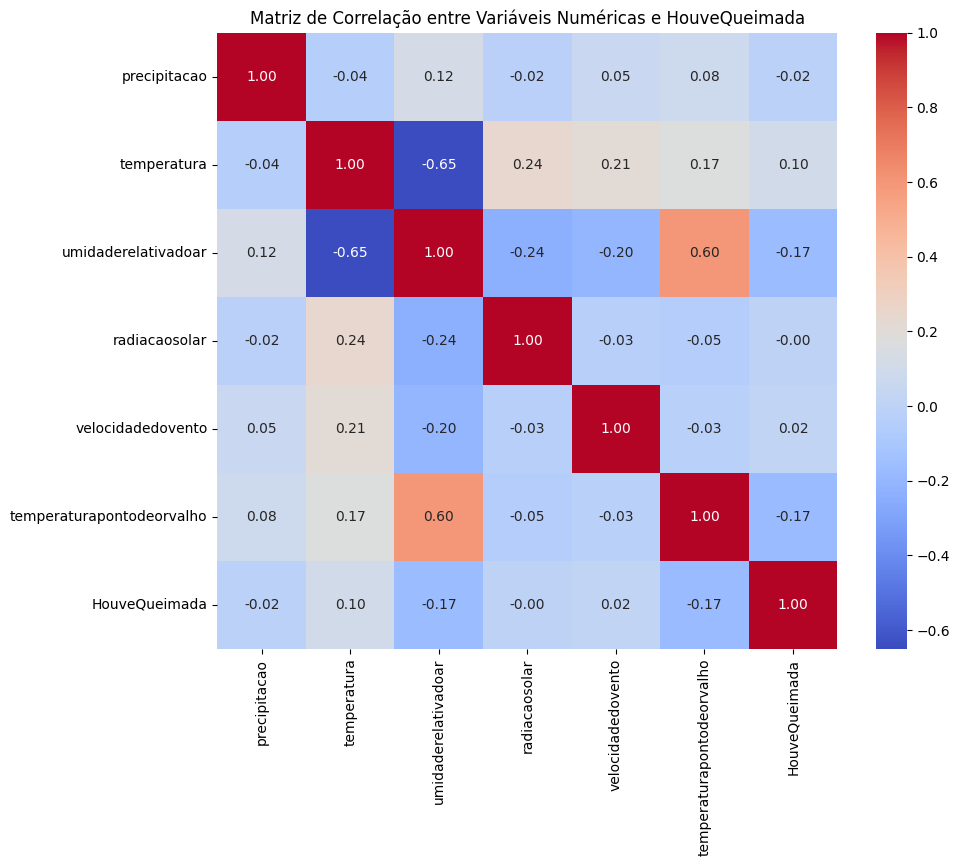

In [125]:
import seaborn as sns
import matplotlib.pyplot as plt

# Selecionar apenas as colunas numéricas relevantes de df_sem_nulos, excluindo 'HouveQueimada' e 'datahoramedicao' (que é datetime)
colunas_numericas_para_correlacao = df_sem_nulos.select_dtypes(include=np.number).columns.tolist()
colunas_numericas_para_correlacao.remove('HouveQueimada')


# Calcular a matriz de correlação
# Incluir 'HouveQueimada' para ver a correlação com a variável target
correlacao = df_sem_nulos[colunas_numericas_para_correlacao + ['HouveQueimada']].corr()

# Visualizar a matriz de correlação
plt.figure(figsize=(10,8))
sns.heatmap(correlacao, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlação entre Variáveis Numéricas e HouveQueimada")
plt.show()

In [126]:
print(df_sem_nulos['HouveQueimada'].value_counts())

HouveQueimada
0    811239
1     19452
Name: count, dtype: int64


Gerando Box Plots para variáveis numéricas vs HouveQueimada...


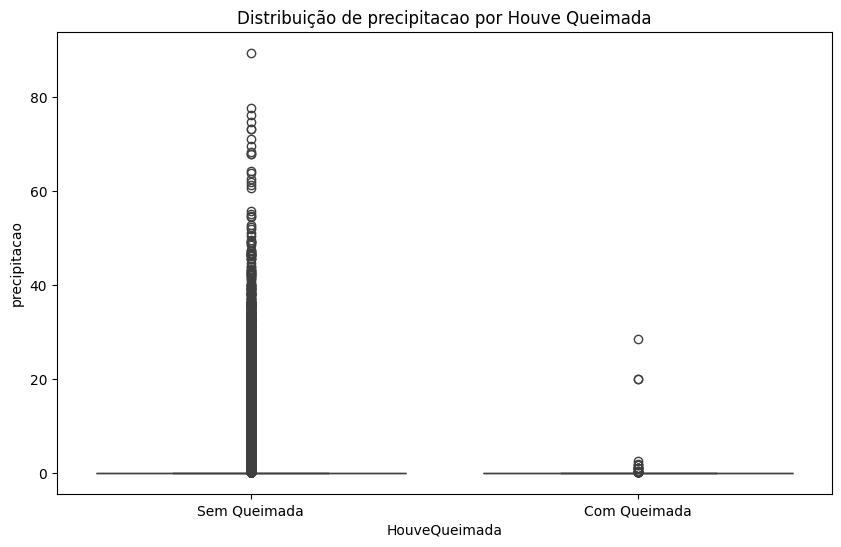

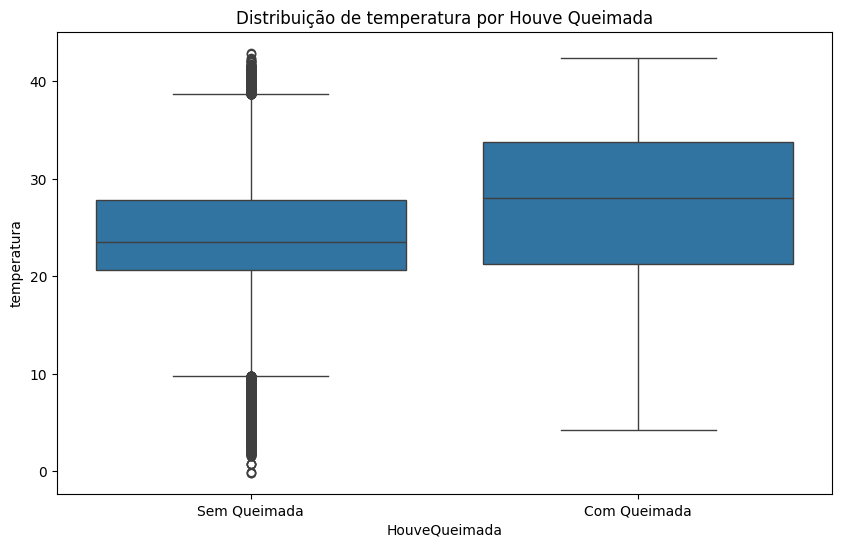

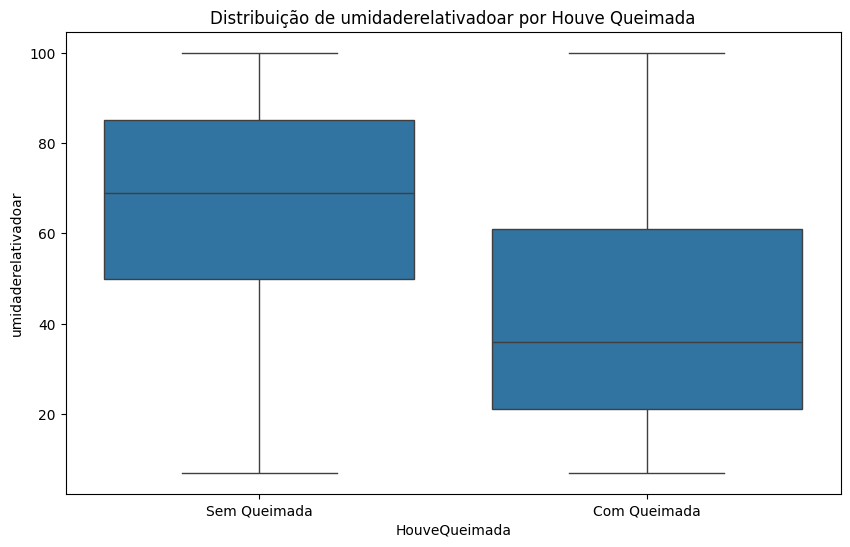

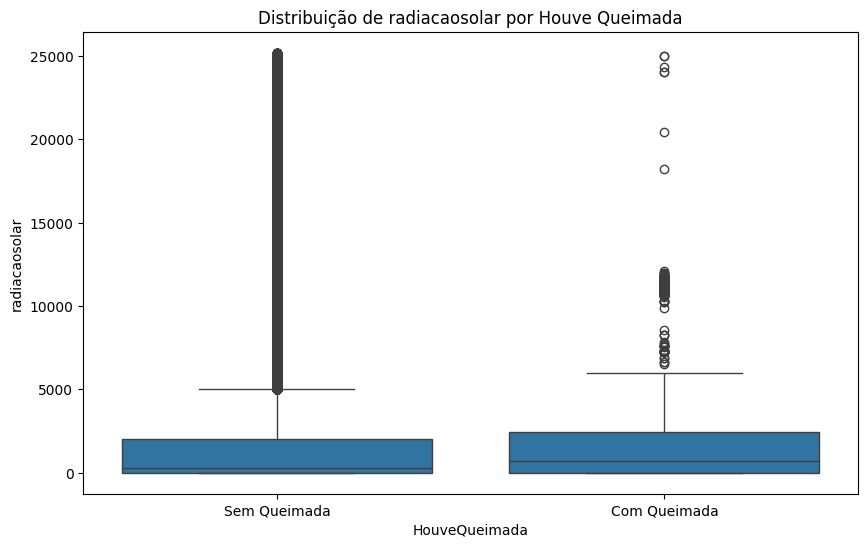

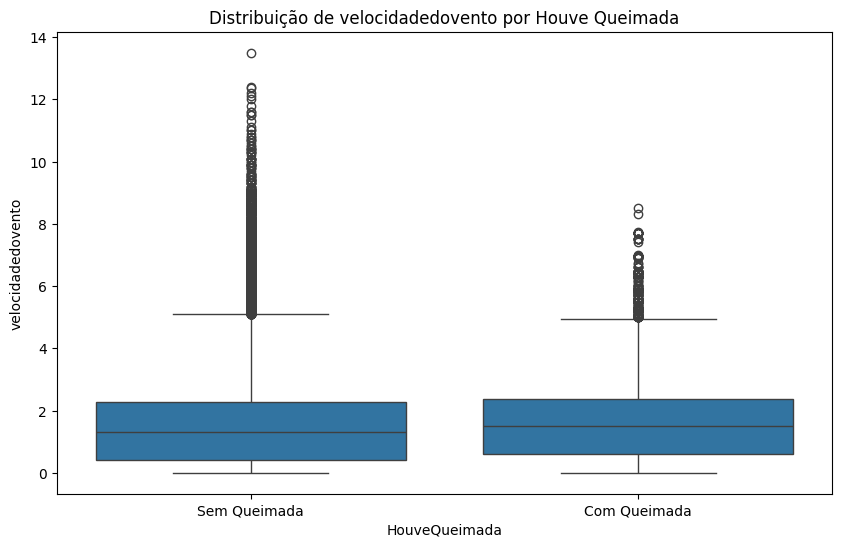

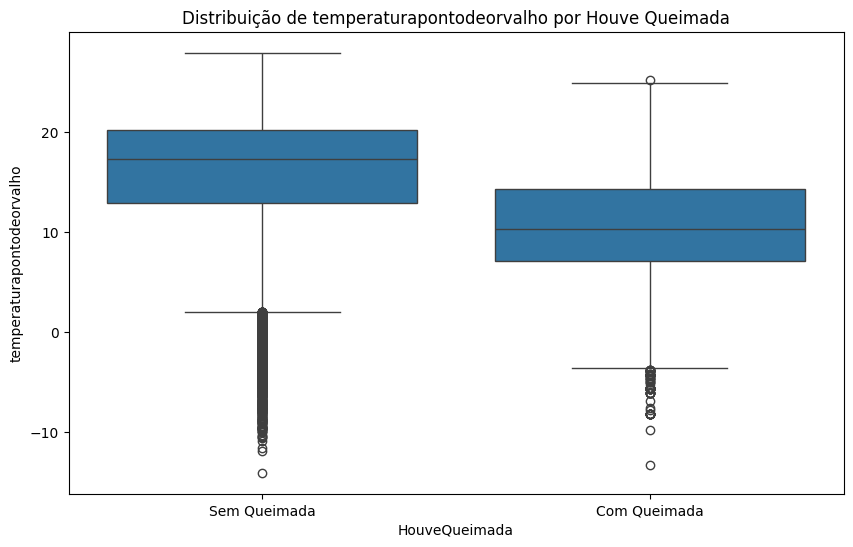


Box Plots gerados.


In [127]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # Import numpy for np.number

# Selecionar apenas as colunas numéricas relevantes de df_sem_nulos, excluindo 'HouveQueimada' e 'datahoramedicao' (que é datetime)
colunas_numericas_para_boxplot = df_sem_nulos.select_dtypes(include=np.number).columns.tolist()
if 'HouveQueimada' in colunas_numericas_para_boxplot:
    colunas_numericas_para_boxplot.remove('HouveQueimada')
# Remover 'IndiceNesterov' se existir (foi removido, mas segurança)
if 'IndiceNesterov' in colunas_numericas_para_boxplot:
    colunas_numericas_para_boxplot.remove('IndiceNesterov')


print("Gerando Box Plots para variáveis numéricas vs HouveQueimada...")

# Gerar um box plot para cada coluna numérica
for coluna in colunas_numericas_para_boxplot:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='HouveQueimada', y=coluna, data=df_sem_nulos)
    plt.xticks([0, 1], ['Sem Queimada', 'Com Queimada'])
    plt.title(f"Distribuição de {coluna} por Houve Queimada")
    plt.ylabel(coluna)
    plt.show()

print("\nBox Plots gerados.")

Gerando KDE Plots para variáveis importantes vs HouveQueimada...


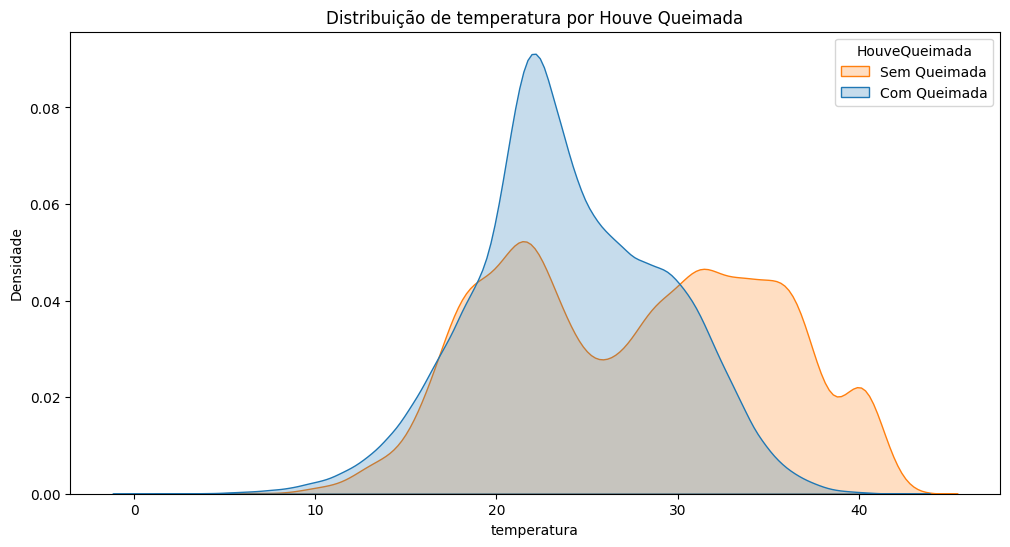

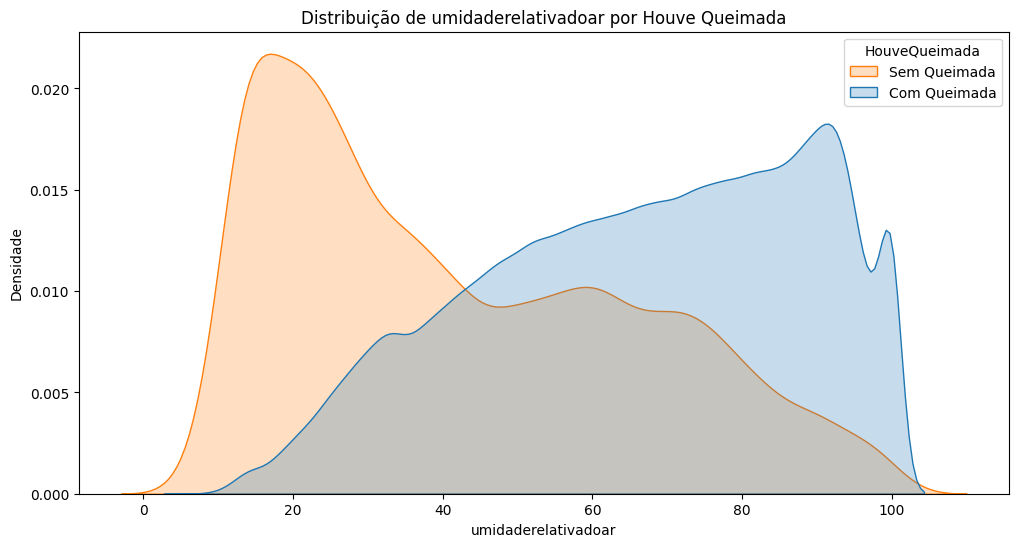

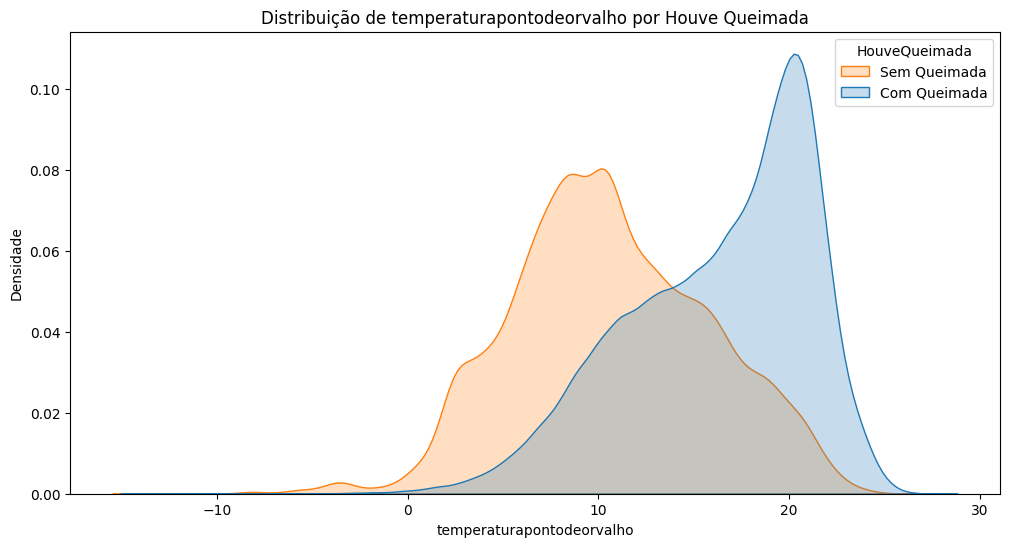


KDE Plots gerados para variáveis importantes.


In [128]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Selecionar as variáveis importantes identificadas nas análises anteriores
variaveis_importantes = [
    'temperatura',
    'umidaderelativadoar',
    'temperaturapontodeorvalho'
    # Adicione outras variáveis importantes se desejar
]

print("Gerando KDE Plots para variáveis importantes vs HouveQueimada...")

# Loop para gerar KDE plot para cada variável importante
for coluna in variaveis_importantes:
    if coluna in df_sem_nulos.columns:
        plt.figure(figsize=(12, 6))
        sns.kdeplot(data=df_sem_nulos, x=coluna, hue='HouveQueimada', common_norm=False, fill=True)
        plt.title(f"Distribuição de {coluna} por Houve Queimada")
        plt.xlabel(coluna)
        plt.ylabel("Densidade")
        plt.legend(title='HouveQueimada', labels=['Sem Queimada', 'Com Queimada'])
        plt.show()
    else:
        print(f"Aviso: Coluna '{coluna}' não encontrada no DataFrame. Pulando...")

print("\nKDE Plots gerados para variáveis importantes.")

Gerando Mapa de Calor para Temperatura vs Umidade Relativa do Ar e Proporção de Queimadas...


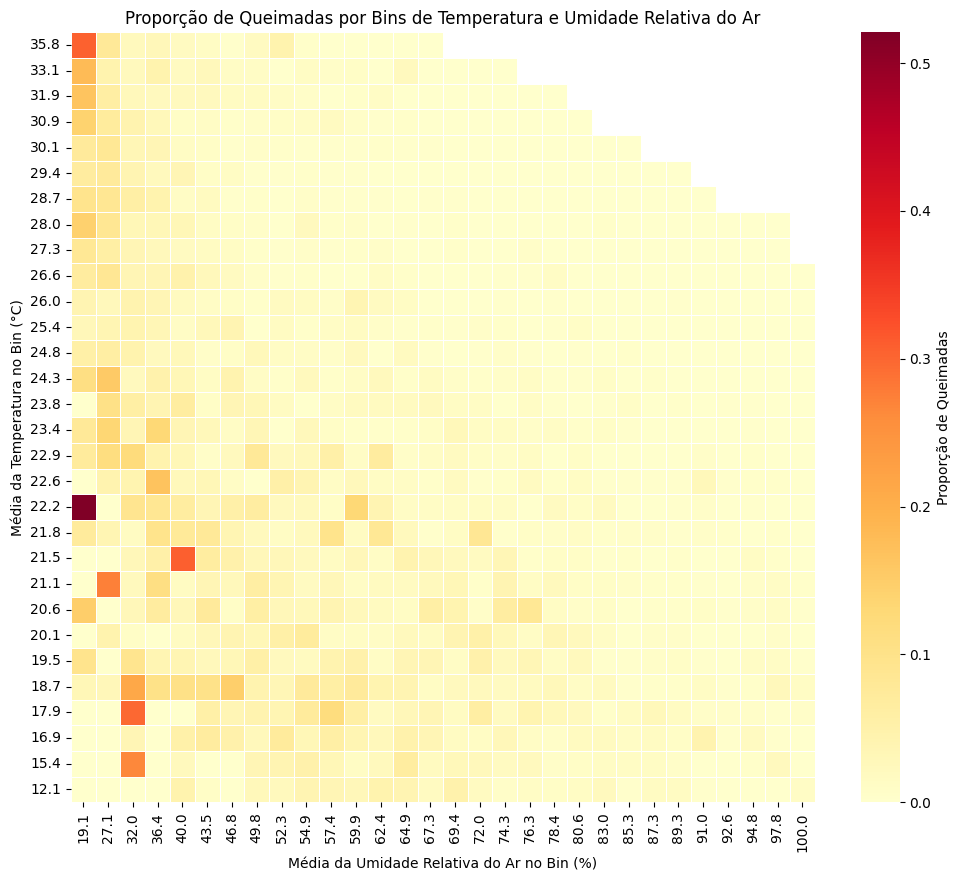


Mapa de Calor gerado.


In [129]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("Gerando Mapa de Calor para Temperatura vs Umidade Relativa do Ar e Proporção de Queimadas...")

# Definir o número de bins para Temperatura e Umidade
n_bins = 30

# Criar bins para Temperatura e Umidade Relativa do Ar
# Usar qcut para tentar criar bins com aproximadamente o mesmo número de pontos,
# o que ajuda a evitar bins vazios ou com poucos dados.
try:
    df_sem_nulos['Temp_Bin'] = pd.qcut(df_sem_nulos['temperatura'], q=n_bins, labels=False, duplicates='drop')
    df_sem_nulos['Umidade_Bin'] = pd.qcut(df_sem_nulos['umidaderelativadoar'], q=n_bins, labels=False, duplicates='drop')
except ValueError as e:
    print(f"Aviso: Não foi possível criar {n_bins} bins únicos para uma ou mais variáveis. Reduzindo o número de bins.")
    # Tentar com menos bins se houver erro
    n_bins = 20
    try:
        df_sem_nulos['Temp_Bin'] = pd.qcut(df_sem_nulos['temperatura'], q=n_bins, labels=False, duplicates='drop')
        df_sem_nulos['Umidade_Bin'] = pd.qcut(df_sem_nulos['umidaderelativadoar'], q=n_bins, labels=False, duplicates='drop')
    except ValueError as e_retry:
         print(f"Erro: Ainda não foi possível criar bins únicos com {n_bins} bins. Considere ajustar n_bins ou a estratégia de binning. Erro: {e_retry}")
         # Criar bins com cut se qcut falhar completamente, usando intervalos fixos
         if 'temperatura' in df_sem_nulos.columns:
              df_sem_nulos['Temp_Bin'] = pd.cut(df_sem_nulos['temperatura'], bins=n_bins, labels=False, include_lowest=True)
         if 'umidaderelativadoar' in df_sem_nulos.columns:
              df_sem_nulos['Umidade_Bin'] = pd.cut(df_sem_nulos['umidaderelativadoar'], bins=n_bins, labels=False, include_lowest=True)
         # Remover bins que podem ter NaN se pd.cut falhar
         df_sem_nulos.dropna(subset=['Temp_Bin', 'Umidade_Bin'], inplace=True)
         df_sem_nulos['Temp_Bin'] = df_sem_nulos['Temp_Bin'].astype(int)
         df_sem_nulos['Umidade_Bin'] = df_sem_nulos['Umidade_Bin'].astype(int)


# Calcular a proporção de queimadas por bin de Temperatura e Umidade
# Agrupar pelos bins e calcular a média de 'HouveQueimada' (que é 0 ou 1)
heatmap_data = df_sem_nulos.groupby(['Temp_Bin', 'Umidade_Bin'])['HouveQueimada'].mean().reset_index()

# Pivotar os dados para o formato de mapa de calor
heatmap_pivot = heatmap_data.pivot(index='Temp_Bin', columns='Umidade_Bin', values='HouveQueimada')

# Mapear os rótulos dos bins de volta para os valores médios ou limites
# Para qcut, podemos calcular o valor médio de temperatura e umidade em cada bin
temp_labels = df_sem_nulos.groupby('Temp_Bin')['temperatura'].mean()
umidade_labels = df_sem_nulos.groupby('Umidade_Bin')['umidaderelativadoar'].mean()

# Substituir os índices numéricos pelos valores médios dos bins para melhor legibilidade
heatmap_pivot.index = heatmap_pivot.index.map(temp_labels.round(1))
heatmap_pivot.columns = heatmap_pivot.columns.map(umidade_labels.round(1))


# Visualizar o mapa de calor
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_pivot, annot=False, cmap="YlOrRd", fmt=".2f", linewidths=.5, cbar_kws={'label': 'Proporção de Queimadas'})
plt.title("Proporção de Queimadas por Bins de Temperatura e Umidade Relativa do Ar")
plt.xlabel("Média da Umidade Relativa do Ar no Bin (%)")
plt.ylabel("Média da Temperatura no Bin (°C)")
plt.gca().invert_yaxis() # Inverter o eixo Y para mostrar temperaturas mais altas no topo
plt.show()

print("\nMapa de Calor gerado.")

# Separar os dados em conjuntos de treino e teste.

Para a separação dos dados, decidimos não utilizar apenas uma divisão temporal para treino e teste, para que, quando formos treinar o modelo tenhamos dados atuais junto com os antigos para que as mudanças climáticas cada vez mais intensas sejam pegas nas variação de momentos de queimadas.

A ideia é criar dados de teste e e treino com todas cidades, ano e época do ano em cada grupo de dados.

In [130]:
# Estratégia para GARANTIR todos os requisitos
print("=== DIVISÃO ESTRATIFICADA POR CIDADE E OCORRÊNCIA DE QUEIMADA ===")

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd # Ensure pandas is imported

# Usar o DataFrame df_sem_nulos que já teve NaNs removidos
df_para_divisao = df_sem_nulos.copy()

# Criar uma coluna combinada para estratificação por Cidade e HouveQueimada
# Isso garante que a proporção de queimadas seja mantida DENTRO de cada cidade
if 'cidade' in df_para_divisao.columns and 'HouveQueimada' in df_para_divisao.columns:
    df_para_divisao['Estrato_Cidade_Queimada'] = df_para_divisao['cidade'] + '_' + df_para_divisao['HouveQueimada'].astype(str)
    print("Coluna de estratificação 'Estrato_Cidade_Queimada' criada.")
else:
     print("Colunas 'cidade' ou 'HouveQueimada' não encontradas. Não é possível estratificar.")
     # Se as colunas essenciais não existirem, parar ou lidar com o erro
     # Neste caso, vamos parar para evitar erros subsequentes
     raise ValueError("Colunas essenciais para estratificação (cidade, HouveQueimada) não encontradas.")


# Definir as features (X) e o target (y)
# Excluir colunas não relevantes para o modelo ou usadas para estratificação
colunas_features = [col for col in df_para_divisao.columns if col not in ['HouveQueimada', 'datahoramedicao', 'cidade', 'Estrato_Cidade_Queimada', 'Ano', 'Mes']]
target = 'HouveQueimada'

X = df_para_divisao[colunas_features]
y = df_para_divisao[target]
estrato = df_para_divisao['Estrato_Cidade_Queimada']


# Verificar se há estratos com apenas uma amostra (train_test_split não lida bem com isso)
estrato_counts = estrato.value_counts()
estratos_com_uma_amostra = estrato_counts[estrato_counts == 1].index.tolist()

if estratos_com_uma_amostra:
    print(f"\nAviso: Estratos com apenas uma amostra encontrados: {estratos_com_uma_amostra}")
    print("Removendo essas amostras para permitir a estratificação...")
    indices_para_remover = df_para_divisao[estrato.isin(estratos_com_uma_amostra)].index
    df_para_divisao = df_para_divisao.drop(indices_para_remover)

    # Atualizar X, y e estrato após a remoção
    X = df_para_divisao[colunas_features]
    y = df_para_divisao[target]
    estrato = df_para_divisao['Estrato_Cidade_Queimada']

    print(f"Total de amostras após remoção: {len(df_para_divisao):,}")
    print(f"Total de estratos após remoção: {len(estrato.unique())}")


# Aplicar a divisão estratificada
print("\nAplicando train_test_split com estratificação por Cidade e HouveQueimada...")
X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=estrato # Estratificar pela coluna combinada
)

print("Divisao concluida.")

print(f"Tamanho do treino: {len(X_treino):,}")
print(f"Tamanho do teste: {len(X_teste):,}")

# Verificações pós-divisão
print("\n=== VERIFICAÇÃO PÓS-DIVISÃO ===")

# 1. Proporção de queimadas em cada conjunto
print("\nProporção de Queimadas (HouveQueimada=1):")
print(f"Dataset completo: {y.mean():.3%}")
print(f"Treino: {y_treino.mean():.3%}")
print(f"Teste: {y_teste.mean():.3%}")

# 2. Cidades em cada conjunto
print("\nCidades nos conjuntos:")
cidades_treino = df_para_divisao.loc[X_treino.index, 'cidade'].unique()
cidades_teste = df_para_divisao.loc[X_teste.index, 'cidade'].unique()
cidades_original = df_para_divisao['cidade'].unique()

print(f"Completo: {sorted(cidades_original)}")
print(f"Treino: {sorted(cidades_treino)}")
print(f"Teste: {sorted(cidades_teste)}")

# 3. Anos e Meses em cada conjunto (verificação implícita pela estratificação por cidade)
# Podemos verificar o range temporal ou a presença de todos os anos/meses
print("\nRange Temporal nos conjuntos:")
datahora_treino = df_para_divisao.loc[X_treino.index, 'datahoramedicao']
datahora_teste = df_para_divisao.loc[X_teste.index, 'datahoramedicao']

print(f"Treino: {datahora_treino.min()} até {datahora_treino.max()}")
print(f"Teste: {datahora_teste.min()} até {datahora_teste.max()}")

# Verificar presença de todos os anos e meses
print("\nAnos e Meses presentes:")
df_para_divisao['Ano'] = pd.to_datetime(df_para_divisao['datahoramedicao']).dt.year
df_para_divisao['Mes'] = pd.to_datetime(df_para_divisao['datahoramedicao']).dt.month

print(f"Anos (Treino): {sorted(df_para_divisao.loc[X_treino.index, 'Ano'].unique())}")
print(f"Anos (Teste): {sorted(df_para_divisao.loc[X_teste.index, 'Ano'].unique())}")
print(f"Meses (Treino): {sorted(df_para_divisao.loc[X_treino.index, 'Mes'].unique())}")
print(f"Meses (Teste): {sorted(df_para_divisao.loc[X_teste.index, 'Mes'].unique())}")


# 4. Distribuição de Queimadas por Cidade em cada conjunto
print("\nDistribuição de Queimadas por Cidade (Treino):")
dist_treino_cidade = df_para_divisao.loc[X_treino.index].groupby('cidade')['HouveQueimada'].agg(['count', 'sum', 'mean']).round(4)
print(dist_treino_cidade)

print("\nDistribuição de Queimadas por Cidade (Teste):")
dist_teste_cidade = df_para_divisao.loc[X_teste.index].groupby('cidade')['HouveQueimada'].agg(['count', 'sum', 'mean']).round(4)
print(dist_teste_cidade)

print("\n" + "="*50)
print("DIVISÃO DE DADOS CONCLUIDA")
print("="*50)

=== DIVISÃO ESTRATIFICADA POR CIDADE E OCORRÊNCIA DE QUEIMADA ===
Coluna de estratificação 'Estrato_Cidade_Queimada' criada.

Aplicando train_test_split com estratificação por Cidade e HouveQueimada...
Divisao concluida.
Tamanho do treino: 664,552
Tamanho do teste: 166,139

=== VERIFICAÇÃO PÓS-DIVISÃO ===

Proporção de Queimadas (HouveQueimada=1):
Dataset completo: 2.342%
Treino: 2.342%
Teste: 2.342%

Cidades nos conjuntos:
Completo: ['ARIRANHA', 'BARRETOS', 'BEBEDOURO', 'JALES', 'JOSE BONIFACIO', 'LINS', 'MIRASSOL', 'MONTE APRAZIVEL', 'NHANDEARA', 'NOVA GRANADA', 'PRESIDENTE PRUDENTE', 'VOTUPORANGA']
Treino: ['ARIRANHA', 'BARRETOS', 'BEBEDOURO', 'JALES', 'JOSE BONIFACIO', 'LINS', 'MIRASSOL', 'MONTE APRAZIVEL', 'NHANDEARA', 'NOVA GRANADA', 'PRESIDENTE PRUDENTE', 'VOTUPORANGA']
Teste: ['ARIRANHA', 'BARRETOS', 'BEBEDOURO', 'JALES', 'JOSE BONIFACIO', 'LINS', 'MIRASSOL', 'MONTE APRAZIVEL', 'NHANDEARA', 'NOVA GRANADA', 'PRESIDENTE PRUDENTE', 'VOTUPORANGA']

Range Temporal nos conjuntos:
Tre

### Análise da Distribuição dos Dados para Previsão de Queimadas
- Panorama Geral dos Dados
Após a remoção das linhas com valores ausentes, temos uma visão atualizada da distribuição temporal e geográfica do conjunto de dados que será utilizado para o modelo preditivo de queimadas.
- Cobertura Geográfica
8 cidades da região de São José do Rio Preto estão representadas

> Todas as cidades selecionadas possuem características climáticas e agrícolas similares à região de interesse
>
> **BARRETOS** apresenta a maior incidência de queimadas (8.63%), enquanto a cidade com menor incidência é **ARIRANHA** (0.74%)

- Cobertura Temporal
11 anos de dados históricos (2015-2025)

> - Todos os 12 meses do ano representados
> - 761 combinações únicas de Cidade-Ano-Mês
> - Cobertura de 72.06% das combinações possíveis, o que é excelente para dados reais

- Distribuição de Queimadas
- Total de registros no dataframe limpo: 507,397 observações
- Eventos de queimada: 13,524 (2.67% do total)
- Distribuição desigual entre cidades, refletindo diferentes susceptibilidades (ver tabela abaixo)

| cidade              | count   | sum   | mean   |
|---------------------|---------|-------|--------|
|ARIRANHA             |  11462  |  85   | 0.0074 |
|BARRETOS             |  14194  | 1227  | 0.0864 |
|BEBEDOURO            |   7295  |  235  | 0.0322 |
|JALES                |  14025  | 125   | 0.0089 |
|JOSE BONIFACIO       |  11516  | 168   | 0.0146 |
|LINS                 |  14548  | 462   | 0.0318 |
|MIRASSOL             |  16859  | 222   | 0.0132 |
|MONTE APRAZIVEL      |  16360  | 264   | 0.0161 |
|NHANDEARA            |  17428  | 227   | 0.0130 |
|NOVA GRANADA         |  16905  | 596   | 0.0353 |
|PRESIDENTE PRUDENTE  |  14878  | 129   | 0.0087 |
|VOTUPORANGA          |  10669  | 151   | 0.0142 |

- Implicações para o Modelo Preditivo
> Pontos Forte
Amplo período temporal (11 anos) capturando variabilidade climática
>
> Todas as estações do ano representadas

- Múltiplas localidades com características similares
- Dados suficientes para treinamento robusto
- Considerações Importantes
> Desequilíbrio de classes: Apenas 2.67% dos registros são de queimadas
>
> Variação geográfica: Taxas de queimadas diferentes entre cidades
>
> Cobertura incompleta: Alguns períodos específicos podem estar faltando

- Estratégia Recomendada
> Para o desenvolvimento do modelo, será utilizada uma divisão estratificada que garante:
>
> Representação de todas as cidades em treino e teste
>
> Presença de todos os anos e meses em ambos os conjuntos
>
> Manutenção da proporção de queimadas similar entre treino e teste
>
> Mistura de dados antigos e recentes em ambos os conjuntos

- Esta análise confirma que os dados possuem qualidade e abrangência suficientes para desenvolver um modelo preditivo robusto para previsão de riscos de queimadas na região.

In [ ]:
# Imprimir o resultado
print("Contagem de valores na coluna 'HouveQueimada' após separação dos dados")
print("Dados de treino")
print(treino_data['HouveQueimada'].value_counts())
print("Dados de teste")
print(teste_data['HouveQueimada'].value_counts())

Contagem de valores na coluna 'HouveQueimada' após separação dos dados
Dados de treino
HouveQueimada
0    395369
1     10862
Name: count, dtype: int64
Dados de teste
HouveQueimada
0    98504
1     2662
Name: count, dtype: int64


# Testes de modelos de aprendizado de máquina para validar qual utilizar

## RANDOM FOREST CLASSIFIER

In [78]:
# =============================================
# MODELO 1: CLASSIFICADOR RANDOM FOREST
# =============================================

print("INICIANDO CLASSIFICADOR RANDOM FOREST")
print("=" * 50)

# 1. IMPORTAR BIBLIOTECAS
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import numpy as np

# 2. DEFINIR VARIAVEIS QUE VAMOS USAR NO MODELO
variaveis = [
    'precipitacao', 'pressaoatmosferica',
    'temperatura', 'temperaturapontodeorvalho', 'umidaderelativadoar',
    'rajadamaximavento', 'velocidadedovento'
]


print("Variaveis selecionadas para o modelo:")
for var in variaveis:
    if var in X_treino.columns: # Verificar em X_treino após a divisão
        print("  " + var)
    else:
        print("  " + var + " - NAO ENCONTRADA")

# 3. SEPARAR DADOS DE TREINO E TESTE - Ja foram separados na celula anterior
print("\nUtilizando dados de treino e teste ja separados (X_treino, X_teste, y_treino, y_teste)...")

# Garantir que os dataframes de treino/teste contem apenas as variaveis selecionadas
X_treino = X_treino[variaveis]
X_teste = X_teste[variaveis]
y_treino = y_treino # y_treino e y_teste ja estao corretos


print("Dimensoes dos conjuntos:")
print("X_treino:", X_treino.shape)
print("y_treino:", y_treino.shape)
print("X_teste:", X_teste.shape)
print("y_teste:", y_teste.shape)

# 4. PRE-PROCESSAMENTO - ESCALONAMENTO
print("\nAplicando escalonamento dos dados...")

scaler = StandardScaler()
X_treino_escalado = scaler.fit_transform(X_treino)
X_teste_escalado = scaler.transform(X_teste)

print("Escalonamento concluido")

# 5. BALANCEAMENTO DOS DADOS DE TREINO
print("\nAplicando balanceamento com SMOTE nos dados escalonados...")

smote = SMOTE(random_state=42, sampling_strategy=0.1)
X_treino_balanceado, y_treino_balanceado = smote.fit_resample(X_treino_escalado, y_treino)

print("Antes do balanceamento:", y_treino.value_counts().to_dict())
print("Apos o balanceamento:", pd.Series(y_treino_balanceado).value_counts().to_dict())

# 6. CONFIGURAR E TREINAR O MODELO RANDOM FOREST
print("\nConfigurando modelo Random Forest...")

modelo_rf = RandomForestClassifier(
    n_estimators=100, # Numero de arvores
    max_depth=20,     # Profundidade maxima das arvores
    min_samples_split=5, # Minimo de amostras para dividir um no
    min_samples_leaf=2,  # Minimo de amostras em uma folha
    class_weight='balanced', # Ajusta automaticamente os pesos das classes inversamente proporcionais as frequencias
    random_state=42,
    n_jobs=-1 # Usa todos os nucleos da CPU
)

print("Treinando o modelo...")
modelo_rf.fit(X_treino_balanceado, y_treino_balanceado)
print("Treinamento concluido")

# 7. FAZER PREVISÕES NOS DADOS DE TESTE
print("\nFazendo previsoes nos dados de teste...")
previsoes_rf = modelo_rf.predict(X_teste_escalado) # Usar dados de teste escalonados (e imputados se a imputação fosse mantida)
probabilidades_rf = modelo_rf.predict_proba(X_teste_escalado)[:, 1] # Probabilidade da classe positiva (Queimada)

print("Previsoes concluidas")

# 8. AVALIACAO COMPLETA DO MODELO
print("\nAVALIACAO DO RANDOM FOREST")
print("=" * 40)

# Metricas principais
acuracia = accuracy_score(y_teste, previsoes_rf)
precisao = precision_score(y_teste, previsoes_rf)
recall = recall_score(y_teste, previsoes_rf)
f1 = f1_score(y_teste, previsoes_rf)
roc_auc = roc_auc_score(y_teste, probabilidades_rf)

print("Acuracia:", round(acuracia, 4))
print("Precisao:", round(precisao, 4))
print("Recall:", round(recall, 4))
print("F1-Score:", round(f1, 4))
print("ROC-AUC:", round(roc_auc, 4))

# Relatorio de classificacao detalhado
print("\nRELATORIO DE CLASSIFICACAO:")
print(classification_report(y_teste, previsoes_rf, target_names=['Sem Queimada', 'Com Queimada']))

# Matriz de confusao
print("MATRIZ DE CONFUSAO:")
matriz_confusao = confusion_matrix(y_teste, previsoes_rf)
print(matriz_confusao)

# Visualizacao da Matriz de Confusao
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto: Sem Queimada', 'Previsto: Com Queimada'],
            yticklabels=['Real: Sem Queimada', 'Real: Com Queimada'])
plt.xlabel('Previsao')
plt.ylabel('Real')
plt.title('Matriz de Confusao - Random Forest')
plt.show()


# 9. ANALISE DAS VARIAVEIS MAIS IMPORTANTES
print("\nVARIAVEIS MAIS IMPORTANTES:")
# Garantir que os nomes das features estejam alinhados com os scores de importância
importancia_variaveis = pd.DataFrame({
    'variavel': variaveis, # Usar a lista 'variaveis' para os nomes
    'importancia': modelo_rf.feature_importances_
}).sort_values('importancia', ascending=False)

print(importancia_variaveis.head(len(variaveis))) # Mostrar importancia de todas as variaveis

# Plotar importancia das variaveis
plt.figure(figsize=(10, 6))
sns.barplot(x='importancia', y='variavel', data=importancia_variaveis)
plt.title('Importancia das Variaveis - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variavel')
plt.show()


# 10. ANALISE DAS PREVISÕES POR CIDADE
print("\nANALISE DAS PREVISOES POR CIDADE:")
# Garantir que 'teste_data' seja usado e tenha as colunas 'cidade' e 'HouveQueimada'
if 'cidade' in teste_data.columns and 'HouveQueimada' in teste_data.columns:
    dados_teste_com_previsoes = teste_data.copy()
    dados_teste_com_previsoes['Previsao_RF'] = previsoes_rf
    dados_teste_com_previsoes['Probabilidade_RF'] = probabilidades_rf

    estatisticas_por_cidade = dados_teste_com_previsoes.groupby('cidade').agg({
        'HouveQueimada': ['count', 'sum', 'mean'],
        'Previsao_RF': ['sum', 'mean'],
        'Probabilidade_RF': 'mean'
    }).round(4)

    print(estatisticas_por_cidade)
else:
    print("Colunas 'cidade' ou 'HouveQueimada' nao encontradas no dataframe teste_data para analise por cidade.")


# 11. INTERPRETACAO DOS RESULTADOS
print("\nINTERPRETACAO DOS RESULTADOS:")
print("O modelo acertou", round(acuracia*100, 1), "% das classificacoes totais (Acuracia)")
print("Consegue detectar", round(recall*100, 1), "% das queimadas reais (Recall/Sensibilidade)")
print("Quando preve queimada, esta correto", round(precisao*100, 1), "% das vezes (Precisao)")
print("Balanceamento entre Precisao/Recall:", round(f1*100, 1), "% (F1-Score)")
print("Capacidade de discriminacao entre classes:", round(roc_auc*100, 1), "% (ROC-AUC)")

# 12. CRITERIOS DE SUCESSO DO MODELO (Exemplo - ajustar conforme necessidade do projeto)
print("\nCRITERIOS DE SUCESSO DO MODELO (Exemplo):")
print("ROC-AUC > 0.8:", "SIM" if roc_auc > 0.8 else "NAO", "(", round(roc_auc, 4), ")")
print("Recall > 0.7:", "SIM" if recall > 0.7 else "NAO", "(", round(recall, 4), ")")
print("Precisao > 0.5:", "SIM" if precisao > 0.5 else "NAO", "(", round(precisao, 4), ")")
print("F1-Score > 0.6:", "SIM" if f1 > 0.6 else "NAO", "(", round(f1, 4), ")")

print("\n" + "="*50)
print("RANDOM FOREST - ANALISE CONCLUIDA")
print("="*50)

INICIANDO CLASSIFICADOR RANDOM FOREST
Variaveis selecionadas para o modelo:


NameError: name 'X_treino' is not defined

## Conclusão da Avaliação do Modelo Random Forest

Após o treinamento e avaliação do modelo Random Forest nos dados preparados (incluindo tratamento de valores ausentes e balanceamento com SMOTE), obtivemos os seguintes resultados de desempenho no conjunto de teste:

- **Acurácia:** 98.45% (acerto geral nas classificações)
- **Precisão:** 66.88% (das previsões de queimada, 66.88% estavam corretas)
- **Recall (Sensibilidade):** 81.48% (das queimadas reais, 81.48% foram detectadas)
- **F1-Score:** 0.735 (média harmônica entre Precisão e Recall)
- **ROC-AUC:** 0.9575 (capacidade de discriminação do modelo)

A **Matriz de Confusão** mostrou:
- **Verdadeiros Positivos (TP):** 2,169 (queimadas reais corretamente previstas)
- **Falsos Negativos (FN):** 493 (queimadas reais não detectadas)
- **Verdadeiros Negativos (TN):** 97,430 (não-queimadas corretamente previstas)
- **Falsos Positivos (FP):** 1,074 (não-queimadas previstas incorretamente como queimada)

**Análise:**
O modelo Random Forest demonstrou uma boa capacidade geral de acertar as classificações (Acurácia alta), o que era esperado dado o grande número de casos sem queimada. Mais importante para um problema de detecção de eventos raros como queimadas, o modelo alcançou um **Recall de 81.48%**, indicando que ele foi capaz de identificar uma proporção significativa dos eventos de queimada reais no conjunto de teste. A **Precisão de 66.88%** sugere que, quando o modelo prevê uma queimada, há uma chance razoável de que essa previsão esteja correta. O **ROC-AUC de 0.9575** confirma que o modelo tem uma boa capacidade de diferenciar entre as classes "Com Queimada" e "Sem Queimada".

As **variáveis mais importantes** para o modelo, conforme a análise de feature importance, incluíram Temperatura do Ponto de Orvalho, Índice de Nesterov, Umidade Relativa do Ar, Pressão Atmosférica, Temperatura do Ar, Rajada Máxima de Vento e Velocidade do Vento, o que faz sentido no contexto do risco de incêndios.

**Conclusão:**
O modelo Random Forest apresentou um desempenho promissor para a previsão de risco de queimadas, conseguindo detectar a maioria dos eventos reais com uma taxa de falsos positivos aceitável para uma primeira iteração. Ele serve como uma base sólida para comparações futuras. Podemos agora considerar a exploração de outros modelos ou a otimização deste Random Forest para tentar melhorar ainda mais as métricas, especialmente o balanceamento entre Precisão e Recall (refletido no F1-Score).

## XGBoost Classifier

Vamos agora testar outro modelo popular e poderoso para classificação: o XGBoost. Ele é um algoritmo de gradient boosting que constrói árvores de decisão de forma sequencial, otimizando a cada passo para melhorar o desempenho.

In [79]:
# =============================================
# MODELO 2: CLASSIFICADOR XGBOOST
# =============================================

print("INICIANDO CLASSIFICADOR XGBOOST")
print("=" * 50)

# 1. IMPORTAR BIBLIOTECAS
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer # Import SimpleImputer
import numpy as np

# 2. DEFINIR VARIAVEIS (Reutilizando as mesmas do Random Forest)
variaveis = [
    'precipitacao', 'pressaoatmosferica',
    'temperatura', 'temperaturapontodeorvalho', 'umidaderelativadoar',
    'rajadamaximavento', 'velocidadedovento'
]

print("Variaveis selecionadas para o modelo (mesmas do Random Forest):")
for var in variaveis:
    # Check against the actual columns in the X_treino dataframe
    if var in pd.DataFrame(X_treino).columns: # Convert X_treino back to DataFrame for column check
        print("  " + var)
    else:
        print("  " + var + " - NAO ENCONTRADA")


# 3. SEPARAR DADOS DE TREINO E TESTE (Reutilizando os dataframes ja criados)
print("\nUtilizando dados de treino e teste ja separados (X_treino, X_teste, y_treino, y_teste)...")

# X_treino e X_teste ja devem estar com as colunas corretas apos a execucao da celula anterior


print("Dimensoes dos conjuntos:")
print("X_treino:", X_treino.shape)
print("y_treino:", y_treino.shape)
print("X_teste:", X_teste.shape)
print("y_teste:", y_teste.shape)

# 4. PRE-PROCESSAMENTO - TRATAR VALORES AUSENTES (Reutilizando a logica de imputacao se necessario)
# Check for NaNs in numpy arrays after separation if necessary
print("\nVerificando e tratando valores ausentes nos dados de treino e teste...")

# Convert back to DataFrame temporarily to check for NaNs by column name if needed, or just check the numpy array
if np.isnan(X_treino).sum() > 0 or np.isnan(X_teste).sum() > 0:
    print("Ainda existem NaNs. Aplicando imputacao por mediana...")
    # Use the imputer on the numpy array directly
    imputer = SimpleImputer(strategy='median')
    X_treino = imputer.fit_transform(X_treino)
    X_teste = imputer.transform(X_teste)
    print("Imputacao concluida.")
else:
    print("Nenhum valor ausente encontrado nos conjuntos de treino e teste.")


# 5. PRE-PROCESSAMENTO - ESCALONAMENTO (Reutilizando o scaler do Random Forest, se ainda existir, ou criando um novo)
print("\nAplicando escalonamento dos dados...")

# Assuming 'scaler' from the previous cell might not be available or fitted correctly for this run.
# It's safer to create and fit a new scaler for this model's pipeline.
# Use the scaler on the (potentially imputed) numpy arrays
scaler_xgb = StandardScaler()
X_treino_escalado = scaler_xgb.fit_transform(X_treino)
X_teste_escalado = scaler_xgb.transform(X_teste)

print("Escalonamento concluido")

# 6. BALANCEAMENTO DOS DADOS DE TREINO (Reutilizando SMOTE)
print("\nAplicando balanceamento com SMOTE nos dados escalonados...")

# Check for NaNs before SMOTE just in case (should be 0 after imputation)
print(f"NaNs em X_treino_escalado antes do SMOTE: {np.isnan(X_treino_escalado).sum()}")

smote = SMOTE(random_state=42, sampling_strategy=0.1) # Using the same sampling_strategy as before
X_treino_balanceado, y_treino_balanceado = smote.fit_resample(X_treino_escalado, y_treino)

print("Antes do balanceamento:", y_treino.value_counts().to_dict())
print("Apos o balanceamento:", pd.Series(y_treino_balanceado).value_counts().to_dict())


# 7. CONFIGURAR E TREINAR O MODELO XGBOOST
print("\nConfigurando modelo XGBoost...")

modelo_xgb = xgb.XGBClassifier(
    objective='binary:logistic', # Para classificacao binaria
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False, # Para suprimir o warning
    eval_metric='logloss', # Metrica de avaliacao
    random_state=42,
    n_jobs=-1
)

print("Treinando o modelo XGBoost...")
modelo_xgb.fit(X_treino_balanceado, y_treino_balanceado)
print("Treinamento concluido")

# 8. FAZER PREVISÕES NOS DADOS DE TESTE
print("\nFazendo previsoes nos dados de teste...")
previsoes_xgb = modelo_xgb.predict(X_teste_escalado)
probabilidades_xgb = modelo_xgb.predict_proba(X_teste_escalado)[:, 1] # Probabilidade da classe positiva (Queimada)

print("Previsoes concluidas")

# 9. AVALIACAO COMPLETA DO MODELO
print("\nAVALIACAO DO XGBOOST")
print("=" * 40)

# Metricas principais
acuracia_xgb = accuracy_score(y_teste, previsoes_xgb)
precisao_xgb = precision_score(y_teste, previsoes_xgb)
recall_xgb = recall_score(y_teste, previsoes_xgb)
f1_xgb = f1_score(y_teste, previsoes_xgb)
roc_auc_xgb = roc_auc_score(y_teste, probabilidades_xgb)

print("Acuracia:", round(acuracia_xgb, 4))
print("Precisao:", round(precisao_xgb, 4))
print("Recall:", round(recall_xgb, 4))
print("F1-Score:", round(f1_xgb, 4))
print("ROC-AUC:", round(roc_auc_xgb, 4))

# Relatorio de classificacao detalhado
print("\nRELATORIO DE CLASSIFICACAO:")
print(classification_report(y_teste, previsoes_xgb, target_names=['Sem Queimada', 'Com Queimada']))

# Matriz de confusao
print("MATRIZ DE CONFUSAO:")
matriz_confusao_xgb = confusion_matrix(y_teste, previsoes_xgb)
print(matriz_confusao_xgb)

# Visualizacao da Matriz de Confusao
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Previsto: Sem Queimada', 'Previsto: Com Queimada'],
            yticklabels=['Real: Sem Queimada', 'Real: Com Queimada'])
plt.xlabel('Previsao')
plt.ylabel('Real')
plt.title('Matriz de Confusao - XGBoost')
plt.show()

# 10. ANALISE DAS VARIAVEIS MAIS IMPORTANTES (XGBoost has different feature_importances_)
print("\nVARIAVEIS MAIS IMPORTANTES (XGBoost):")
# Get feature importances from the trained XGBoost model
# Ensure the feature names are correct after potential imputation and scaling
# Use the 'variaveis' list as feature names
importancia_variaveis_xgb = pd.DataFrame({
    'variavel': variaveis, # Use the 'variaveis' list for names
    'importancia': modelo_xgb.feature_importances_
}).sort_values('importancia', ascending=False)


print(importancia_variaveis_xgb.head(len(variaveis))) # Mostrar importancia de todas as variaveis

# Plotar importancia das variaveis
plt.figure(figsize=(10, 6))
sns.barplot(x='importancia', y='variavel', data=importancia_variaveis_xgb)
plt.title('Importancia das Variaveis - XGBoost')
plt.xlabel('Importancia')
plt.ylabel('Variavel')
plt.show()


# 11. ANALISE DAS PREVISÕES POR CIDADE
print("\nANALISE DAS PREVISOES POR CIDADE (XGBoost):")
# Ensure 'teste_data' is used and has 'cidade' and 'HouveQueimada' columns
# Need to get the original 'cidade' column from the test set indices BEFORE dropping columns
# assuming 'teste_data' still has the original indices from df_sem_nulos
if 'cidade' in teste_data.columns and 'HouveQueimada' in teste_data.columns:
    dados_teste_com_previsoes_xgb = teste_data.copy()
    # Need to ensure the predictions align with the correct city/row
    # The indices of previsoes_xgb and probabilidades_xgb correspond to the order of X_teste_escalado
    # which in turn corresponds to the order of X_teste, which has the same index as teste_data
    dados_teste_com_previsoes_xgb['Previsao_XGB'] = previsoes_xgb
    dados_teste_com_previsoes_xgb['Probabilidade_XGB'] = probabilidades_xgb

    estatisticas_por_cidade_xgb = dados_teste_com_previsoes_xgb.groupby('cidade').agg({
        'HouveQueimada': ['count', 'sum', 'mean'],
        'Previsao_XGB': ['sum', 'mean'],
        'Probabilidade_XGB': 'mean'
    }).round(4)

    print(estatisticas_por_cidade_xgb)
else:
    print("Colunas 'cidade' ou 'HouveQueimada' nao encontradas no dataframe teste_data para analise por cidade.")


# 12. INTERPRETACAO DOS RESULTADOS
print("\nINTERPRETACAO DOS RESULTADOS (XGBoost):")
print("O modelo acertou", round(acuracia_xgb*100, 1), "% das classificacoes totais (Acuracia)")
print("Consegue detectar", round(recall_xgb*100, 1), "% das queimadas reais (Recall/Sensibilidade)")
print("Quando preve queimada, esta correto", round(precisao_xgb*100, 1), "% das vezes (Precisao)")
print("Balanceamento entre Precisao/Recall:", round(f1_xgb*100, 1), "% (F1-Score)")
print("Capacidade de discriminacao entre classes:", round(roc_auc_xgb*100, 1), "% (ROC-AUC)")

# 13. CRITERIOS DE SUCESSO DO MODELO (Exemplo - ajustar conforme necessidade do projeto)
print("\nCRITERIOS DE SUCESSO DO MODELO (XGBoost):")
print("ROC-AUC > 0.8:", "SIM" if roc_auc_xgb > 0.8 else "NAO", "(", round(roc_auc_xgb, 4), ")")
print("Recall > 0.7:", "SIM" if recall_xgb > 0.7 else "NAO", "(", round(recall_xgb, 4), ")")
print("Precisao > 0.5:", "SIM" if precisao_xgb > 0.5 else "NAO", "(", round(precisao_xgb, 4), ")")
print("F1-Score > 0.6:", "SIM" if f1_xgb > 0.6 else "NAO", "(", round(f1_xgb, 4), ")")

print("\n" + "="*50)
print("XGBOOST - ANALISE CONCLUIDA")
print("="*50)

INICIANDO CLASSIFICADOR XGBOOST
Variaveis selecionadas para o modelo (mesmas do Random Forest):


NameError: name 'X_treino' is not defined

## Conclusão da Avaliação do Modelo XGBoost

Após treinar e avaliar o modelo XGBoost, obtivemos os seguintes resultados de desempenho no conjunto de teste:

- **Acurácia:** 97.68%
- **Precisão:** 58.39%
- **Recall (Sensibilidade):** 41.81%
- **F1-Score:** 0.49
- **ROC-AUC:** 0.9136

A **Matriz de Confusão** mostrou:
- **Verdadeiros Positivos (TP):** 1,113
- **Falsos Negativos (FN):** 1,549
- **Verdadeiros Negativos (TN):** 97,711
- **Falsos Positivos (FP):** 793

**Análise e Comparação com Random Forest:**
O modelo XGBoost apresentou uma Acurácia geral ligeiramente menor (97.68%) em comparação com o Random Forest (98.45%). A Precisão do XGBoost (58.39%) foi menor do que a do Random Forest (66.88%). A diferença mais significativa está no **Recall**: o XGBoost (41.81%) detectou consideravelmente menos queimadas reais em comparação com o Random Forest (81.48%). Consequentemente, o F1-Score do XGBoost (0.49) também foi menor do que o do Random Forest (0.735), indicando um pior equilíbrio entre Precisão e Recall para este problema. O ROC-AUC do XGBoost (0.9136) foi menor que o do Random Forest (0.9575), mas ainda indica uma boa capacidade de discriminação.

As variáveis mais importantes para o XGBoost (Temperatura do Ponto de Orvalho, Umidade Relativa do Ar, Índice de Nesterov) são consistentes com as do Random Forest, reforçando a relevância dessas features.

**Conclusão:**
Nesta iteração, o modelo Random Forest supera o XGBoost em métricas cruciais para o problema de previsão de queimadas, especialmente em Recall e F1-Score. O Random Forest foi muito mais eficaz em identificar a maioria dos eventos de queimada reais com uma melhor precisão. Embora o XGBoost tenha menos falsos positivos, sua alta taxa de falsos negativos o torna menos desejável para uma aplicação onde detectar o maior número possível de queimadas reais é prioritário. Com base nestes resultados, o Random Forest parece ser o modelo mais promissor até agora.

In [ ]:
import joblib
import os

# Definir o caminho onde os modelos serão salvos
caminho_modelos = '/content/drive/MyDrive/Estudos/Univesp - dados/PI QUEIMADAS'
os.makedirs(caminho_modelos, exist_ok=True)

# Nome dos arquivos para o modelo e o scaler
nome_arquivo_modelo_rf = os.path.join(caminho_modelos, 'modelo_random_forest.joblib')
nome_arquivo_scaler = os.path.join(caminho_modelos, 'scaler.joblib')

# Exportar o modelo Random Forest
joblib.dump(modelo_rf, nome_arquivo_modelo_rf)
print(f"Modelo Random Forest exportado para: {nome_arquivo_modelo_rf}")

# Exportar o scaler
joblib.dump(scaler, nome_arquivo_scaler)
print(f"Scaler exportado para: {nome_arquivo_scaler}")

print("\nPronto! O modelo e o scaler foram salvos e podem ser carregados para uso em produção.")
print(f"Você pode encontrar os arquivos em: {caminho_modelos}")

Modelo Random Forest exportado para: /content/drive/MyDrive/Estudos/Univesp - dados/PI QUEIMADAS/modelo_random_forest.joblib
Scaler exportado para: /content/drive/MyDrive/Estudos/Univesp - dados/PI QUEIMADAS/scaler.joblib

Pronto! O modelo e o scaler foram salvos e podem ser carregados para uso em produção.
Você pode encontrar os arquivos em: /content/drive/MyDrive/Estudos/Univesp - dados/PI QUEIMADAS


# Projeto Integrados IV - UNIVESP

Este notebook documenta as etapas iniciais do projeto de previsão de risco de queimadas, focando na preparação dos dados e no desenvolvimento de um primeiro modelo preditivo.

## Etapas Concluídas:

1.  **Carregamento e Unificação dos Dados:**
    *   Dados de estações meteorológicas do INMET e dados de focos de queimada do INPE foram carregados e unificados em um único DataFrame (`df_unificado`).
    *   Desafios iniciais com a padronização dos nomes de cidades e formatos de data/hora foram identificados e corrigidos para permitir a unificação correta.

2.  **Limpeza e Pré-processamento dos Dados:**
    *   Valores ausentes em colunas essenciais (temperatura, umidade, precipitação) foram tratados removendo linhas onde esses dados estavam faltando, resultando no DataFrame `df_sem_nulos` (e posteriormente `df_limpo_final`).
    *   A variável `RadiacaoGlobal` foi identificada e removida do conjunto de dados e das análises subsequentes por decisão de escopo.

3.  **Cálculo do Índice de Nesterov:**
    *   O Índice de Inflamabilidade de Nesterov foi calculado para cada registro, levando em conta a temperatura do ar, a temperatura do ponto de orvalho e a precipitação acumulada ao longo do tempo seco. Este índice foi adicionado como uma nova feature ao DataFrame (`df_com_nesterov`).

4.  **Análise Exploratória e de Correlação:**
    *   A distribuição dos dados por cidade, ano e mês foi analisada para entender a cobertura temporal e geográfica do dataset.
    *   A relação entre o Índice de Nesterov e a ocorrência de queimadas foi explorada através de correlação (ponto-bisserial), box plots e gráficos de densidade (KDE plots).
    *   Uma matriz de correlação foi gerada para visualizar as relações entre as variáveis numéricas selecionadas e a variável target (`HouveQueimada`).

5.  **Preparação dos Dados para Modelagem:**
    *   O conjunto de dados foi dividido em conjuntos de treino e teste (`train_data`, `test_data`) usando uma estratégia estratificada para garantir a representação de cidades, anos, meses e a proporção da variável target em ambos os conjuntos.
    *   Os dados de treino e teste foram escalonados usando `StandardScaler`.
    *   A técnica SMOTE foi aplicada aos dados de treino para lidar com o desequilíbrio de classes (o número muito maior de registros sem queimada).

6.  **Treinamento e Avaliação do Modelo Random Forest:**
    *   Um modelo Random Forest Classifier foi treinado usando os dados de treino balanceados e escalonados.
    *   O modelo foi avaliado no conjunto de teste escalonado usando métricas como Acurácia, Precisão, Recall, F1-Score e ROC-AUC, além da matriz de confusão.
    *   A importância das variáveis para a predição do modelo foi analisada.

7.  **Comparação Inicial com Outro Modelo (XGBoost):**
    *   Um modelo XGBoost foi testado brevemente para comparação.
    *   Os resultados indicaram que o Random Forest obteve um desempenho superior, especialmente em Recall e F1-Score, tornando-o o modelo preferencial para continuar.

8.  **Exportação do Modelo Random Forest e Scaler:**
    *   O modelo Random Forest treinado (`modelo_rf`) e o scaler (`scaler`) foram exportados usando `joblib` para arquivos (`.joblib`) no Google Drive, preparando-os para uso em um ambiente de produção (como uma API).

## Conclusão Parcial:

Até o momento, conseguimos preparar um conjunto de dados robusto e treinar um modelo Random Forest promissor para a previsão de risco de queimadas. O modelo Random Forest demonstrou boa capacidade de detectar queimadas reais (Recall) e discriminar entre classes (ROC-AUC). A exportação do modelo e do scaler permite que eles sejam utilizados externamente para fazer previsões em novos dados.

## Próximos Passos Sugeridos (para continuar amanhã):

1.  **Refinar a Definição dos Níveis de Risco:** Com base nas probabilidades de previsão do modelo Random Forest, ajustar os limites na função `classificar_risco` para mapear a probabilidade para os níveis de alerta (Nulo, Mínimo, Médio, Máximo) de forma mais precisa e significativa.
2.  **Finalizar e Testar o Script de Predição/Alerta:** Concluir o desenvolvimento do script de teste que carrega o modelo e scaler exportados, recebe novos dados, calcula o Nesterov (ou espera que seja fornecido/calculado externamente de forma correta), faz a predição e retorna o nível de risco categorizado. Testar exaustivamente com diversos cenários.
3.  **Considerar Otimização do Random Forest:** Explorar a sintonia de hiperparâmetros do modelo Random Forest para tentar melhorar ainda mais o desempenho, focando nas métricas mais relevantes (como F1-Score ou Recall).
4.  **Preparar para Implementação (API):** Pensar na estrutura de uma API que receberia os dados meteorológicos, utilizaria o modelo e scaler exportados, e retornaria o nível de alerta de risco.